# Adversarial Learned Inference (ALI)

### Data setup

In [1]:
from IPython.display import Image, SVG
%matplotlib inline

import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split

import tensorflow as tf

import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Lambda
import keras.backend as K
from keras import regularizers
from keras import optimizers

bkg_filename = "../../background_Full_Test3.txt"
sig_filename = "../../signal_Full_Test3.txt"

bkg_all = pd.read_csv(bkg_filename, delimiter=' ', index_col=False)
sig_all = pd.read_csv(sig_filename, delimiter=' ', index_col=False)
coordinates_transformed = False

def coordinate_change (df):
    pt1 = np.sqrt(df['px1']**2 + df['py1']**2)
    theta1 = np.arctan2(pt1,df['pz1'])
    eta1 = -1 * np.log(np.tan(theta1/2))
    phi1 = np.arctan2(df['py1'],df['px1'])
    pt2 = np.sqrt(df['px2']**2 + df['py2']**2)
    theta2 = np.arctan2(pt2,df['pz2'])
    eta2 = -1 * np.log(np.tan(theta2/2))
    phi2 = np.arctan2(df['py2'],df['px2'])
    df['px1'] = pt1
    df['py1'] = eta1
    df['pz1'] = phi1
    df['px2'] = pt2
    df['py2'] = eta2
    df['pz2'] = phi2
    df.rename(columns={'px1':'$p_{t1}$', 'py1':'$\eta_{1}$', 'pz1':'$\phi_{1}$', 'px2':'$p_{t2}$',
                       'py2':'$\eta_{2}$', 'pz2':'$\phi_{2}$', 'E1':'$E_1$', 'E2':'$E_2$', 'M1':'$M_1$',
                       'M2':'$M_2$', 'M12':'$M_{1 2}$'}, inplace=True)
    
if coordinates_transformed == False:
    coordinate_change(sig_all)
    coordinate_change(bkg_all)
    coordinates_transformed = True
    
drop_columns = False    

if drop_columns:
    sig_sel = sig_all.drop(columns = ['$\phi_{1}$', '$\phi_{2}$'])
    bkg_sel = bkg_all.drop(columns = ['$\phi_{1}$', '$\phi_{2}$'])
else:
    sig_sel = sig_all
    bkg_sel = bkg_all
    
data_header = list(sig_sel)

sig_shuffled = shuffle(sig_sel)
bkg_shuffled = shuffle(bkg_sel)
n_bkg = 50000
n_sig = 25000
n_train = 25000
n_test_sig = 25000
n_test = 50000


print ("TRAINING sample size:", n_train)
print ("TESTING sample size:", n_test)

sample_train = bkg_sel[:n_train]
sample_test = pd.concat([bkg_sel.iloc[n_train:n_train+25000], sig_sel.iloc[:n_test_sig]])
sample_test = sample_test.reset_index(drop=True)
                                      
    
scaler = MinMaxScaler()
#scaler = StandardScaler()
#scaler = RobustScaler()
#scaler = Normalizer()

sample_train = scaler.fit_transform(sample_train)
sample_test = scaler.transform(sample_test)

print('Trial sample size: ',sample_test.shape)
print('Benchmark sample size: ',sample_train.shape)

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

n_cycle = 0
train_time = 0

print(K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.


TRAINING sample size: 25000
TESTING sample size: 50000
Trial sample size:  (50000, 13)
Benchmark sample size:  (25000, 13)
['/job:localhost/replica:0/task:0/device:GPU:0']


### Generators: Encoder & Decoder
**Note:** The networks *encoder* and *decoder* will not be trained. We define them in order to be used for predictions. Their layers will be included in larger networks where their paramaters will be updated with training

In [2]:
input_dim = sample_train.shape[1]
encoding_dim = 4

enc_in = Input(shape=(input_dim,), name='encoder_input')
enc_layers = Dense(9, activation='relu', name='encoder_hidden_1')(enc_in)
enc_layers = Dense(7, activation='relu', name='encoder_hidden_2')(enc_layers)
enc_layers = Dense(encoding_dim, activation='linear', name='encoder_output')(enc_layers)

encoder = Model(enc_in, enc_layers)
encoder.compile(optimizer='adam', loss='mse')

dec_in = Input(shape=(encoding_dim,), name='decoder_input')
dec_layers = Dense(7, activation='relu', name='decoder_hidden_1')(dec_in)
dec_layers = Dense(9, activation='relu', name='decoder_hidden_2')(dec_layers)
dec_layers = Dense(input_dim, activation='linear', name='decoder_output')(dec_layers)

decoder = Model(dec_in, dec_layers)
decoder.compile(optimizer='adam', loss='mse')

encoder.summary()
decoder.summary()

ae_in = Input(shape=(input_dim,), name='AE_input')
enc_layers = encoder.layers[3](encoder.layers[2](encoder.layers[1](ae_in)))
ae_layers = decoder.layers[3](decoder.layers[2](decoder.layers[1](enc_layers)))
AE = Model (ae_in, ae_layers)
AE.compile(optimizer='adam', loss='mse')
AE.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 13)                0         
_________________________________________________________________
encoder_hidden_1 (Dense)     (None, 9)                 126       
_________________________________________________________________
encoder_hidden_2 (Dense)     (None, 7)                 70        
_________________________________________________________________
encoder_output (Dense)       (None, 4)                 32        
Total params: 228
Trainable params: 228
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 4)                 0         
_________________________________________________________________
decoder_hidd

### Discriminator

In [3]:
dis_in_x = Input(shape=(input_dim,), name='discriminator_input_x')
dis_layers_x = Dense(8, activation='relu', name='discriminator_hidden_x_1')(dis_in_x)
dis_layers_x = Dense(encoding_dim, activation='relu', name='discriminator_hidden_x_2')(dis_layers_x)

dis_in_z = Input(shape=(encoding_dim,), name='discriminator_input_z')
dis_layers_z = Dense(encoding_dim, activation='relu', name='discriminator_hidden_z')(dis_in_z)

dis_in = [dis_in_x, dis_in_z]
dis_merged = keras.layers.concatenate([dis_layers_x, dis_layers_z])
dis_layers_all = Dense(2*encoding_dim, activation='relu', name='discriminator_hidden_all_1')(dis_merged)
dis_layers_all = Dense(encoding_dim, activation='relu', name='discriminator_hidden_all_2')(dis_layers_all)
dis_layers_all = Dense(2, activation='sigmoid', name='discriminator_output')(dis_layers_all)

discriminator = Model(dis_in, dis_layers_all)
discriminator.compile(optimizer='adam', loss='binary_crossentropy')
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
discriminator_input_x (InputLay (None, 13)           0                                            
__________________________________________________________________________________________________
discriminator_hidden_x_1 (Dense (None, 8)            112         discriminator_input_x[0][0]      
__________________________________________________________________________________________________
discriminator_input_z (InputLay (None, 4)            0                                            
__________________________________________________________________________________________________
discriminator_hidden_x_2 (Dense (None, 4)            36          discriminator_hidden_x_1[0][0]   
__________________________________________________________________________________________________
discrimina

### Player1: Encoder

In [4]:
p1_in_x = Input(shape=(input_dim,), name='player1_input_x')
p1_in_z = encoder.layers[3](encoder.layers[2](encoder.layers[1](p1_in_x)))

p1_score_x = discriminator.layers[3](discriminator.layers[1](p1_in_x))
p1_score_z = discriminator.layers[4](p1_in_z)
p1_score_merged = discriminator.layers[6](discriminator.layers[5]([p1_score_x, p1_score_z]))
p1_score = discriminator.layers[8](discriminator.layers[7](p1_score_merged))

player_1 = Model(p1_in_x, p1_score)

player_1.get_layer('discriminator_hidden_x_1').trainable = False
player_1.get_layer('discriminator_hidden_x_2').trainable = False
player_1.get_layer('discriminator_hidden_z').trainable = False
player_1.get_layer('discriminator_hidden_all_1').trainable = False
player_1.get_layer('discriminator_hidden_all_2').trainable = False
player_1.get_layer('discriminator_output').trainable = False

player_1.compile(optimizer='adam', loss='binary_crossentropy')
player_1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
player1_input_x (InputLayer)    (None, 13)           0                                            
__________________________________________________________________________________________________
encoder_hidden_1 (Dense)        (None, 9)            126         player1_input_x[0][0]            
__________________________________________________________________________________________________
encoder_hidden_2 (Dense)        (None, 7)            70          encoder_hidden_1[2][0]           
__________________________________________________________________________________________________
discriminator_hidden_x_1 (Dense (None, 8)            112         player1_input_x[0][0]            
__________________________________________________________________________________________________
encoder_ou

### Player2: Decoder

In [5]:
p2_in_z = Input(shape=(encoding_dim,), name='player2_input_z')
p2_in_x = decoder.layers[3](decoder.layers[2](decoder.layers[1](p2_in_z)))

p2_score_x = discriminator.layers[3](discriminator.layers[1](p2_in_x))
p2_score_z = discriminator.layers[4](p2_in_z)
p2_score_merged = discriminator.layers[6](discriminator.layers[5]([p2_score_x, p2_score_z]))
p2_score = discriminator.layers[8](discriminator.layers[7](p2_score_merged))

player_2 = Model(p2_in_z, p2_score)

player_2.get_layer('discriminator_hidden_x_1').trainable = False
player_2.get_layer('discriminator_hidden_x_2').trainable = False
player_2.get_layer('discriminator_hidden_z').trainable = False
player_2.get_layer('discriminator_hidden_all_1').trainable = False
player_2.get_layer('discriminator_hidden_all_2').trainable = False
player_2.get_layer('discriminator_output').trainable = False

player_2.compile(optimizer='adam', loss='binary_crossentropy')
player_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
player2_input_z (InputLayer)    (None, 4)            0                                            
__________________________________________________________________________________________________
decoder_hidden_1 (Dense)        (None, 7)            35          player2_input_z[0][0]            
__________________________________________________________________________________________________
decoder_hidden_2 (Dense)        (None, 9)            72          decoder_hidden_1[2][0]           
__________________________________________________________________________________________________
decoder_output (Dense)          (None, 13)           130         decoder_hidden_2[2][0]           
__________________________________________________________________________________________________
discrimina

### Training

In [10]:
train_steps = 5000
batch_size = 50
discriminator_history = np.empty([train_steps,2])
game_history = np.empty([train_steps,2])
ae_mse = np.empty(train_steps)

gradient_ascent=-np.ones(batch_size)
y_dec = np.tile([1,0], [batch_size,1])
y_enc = np.tile([0,1], [batch_size,1])

start = time.time()

with tf.device('/GPU:0'):
    for i in range(train_steps):
            #discriminator
            x_sample = sample_train[np.random.randint(0,sample_train.shape[0], size=batch_size)]
            encoded_z = encoder.predict(x_sample)
            xz_enc = [x_sample, encoded_z]
            
            z_sample = np.random.uniform(0, 1.0, size=[batch_size, encoding_dim])
            decoded_x = decoder.predict(z_sample)
            xz_dec = [decoded_x, z_sample]
    
            dis_loss_e = discriminator.train_on_batch(xz_enc, y_enc)
            dis_loss_d = discriminator.train_on_batch(xz_dec, y_dec)
            discriminator_history[i] = [dis_loss_e, dis_loss_d]
            
            #encoder
            x_sample = sample_train[np.random.randint(0,sample_train.shape[0], size=batch_size)]
            p1_loss = player_1.train_on_batch(x_sample, y_dec)
            
            #decoder
            z_sample = np.random.uniform(0, 1.0, size=[batch_size, encoding_dim])
            p2_loss = player_2.train_on_batch(z_sample, y_enc)
            
            #AE mse
            ae_mse[i] = AE.train_on_batch(x_sample, x_sample)
            
            #progress report
            prc = ((i+1)/train_steps)*100
            log_mesg = "%.2f%% [D loss E: %f, D loss D: %f]" % (prc, dis_loss_e, dis_loss_d)
            log_mesg = "%s  [P1 loss: %f, P2 loss: %f]" % (log_mesg, p1_loss, p2_loss)
            log_mesg = "%s  [AE mse: %f]" % (log_mesg, ae_mse[i])
            print(log_mesg)
            game_history[i] = [p1_loss, p2_loss]

end = time.time()
train_time += (end-start)
n_cycle += 1

0.02% [D loss E: 0.669221, D loss D: 0.767690]  [P1 loss: 0.711678, P2 loss: 0.634834]  [AE mse: 0.014609]
0.04% [D loss E: 0.671026, D loss D: 0.757738]  [P1 loss: 0.721451, P2 loss: 0.644986]  [AE mse: 0.014117]
0.06% [D loss E: 0.670829, D loss D: 0.760404]  [P1 loss: 0.723090, P2 loss: 0.640275]  [AE mse: 0.012404]
0.08% [D loss E: 0.671997, D loss D: 0.769049]  [P1 loss: 0.727216, P2 loss: 0.634584]  [AE mse: 0.010180]
0.10% [D loss E: 0.672756, D loss D: 0.760805]  [P1 loss: 0.722051, P2 loss: 0.623150]  [AE mse: 0.012217]
0.12% [D loss E: 0.676326, D loss D: 0.774524]  [P1 loss: 0.723237, P2 loss: 0.623039]  [AE mse: 0.013188]
0.14% [D loss E: 0.672015, D loss D: 0.756711]  [P1 loss: 0.719367, P2 loss: 0.633888]  [AE mse: 0.013968]
0.16% [D loss E: 0.668451, D loss D: 0.753278]  [P1 loss: 0.725482, P2 loss: 0.622334]  [AE mse: 0.013842]
0.18% [D loss E: 0.664490, D loss D: 0.765299]  [P1 loss: 0.719298, P2 loss: 0.639125]  [AE mse: 0.012316]
0.20% [D loss E: 0.673499, D loss D: 

1.84% [D loss E: 0.687711, D loss D: 0.692007]  [P1 loss: 0.699256, P2 loss: 0.699005]  [AE mse: 0.008729]
1.86% [D loss E: 0.696348, D loss D: 0.706572]  [P1 loss: 0.707196, P2 loss: 0.695143]  [AE mse: 0.010448]
1.88% [D loss E: 0.698329, D loss D: 0.683729]  [P1 loss: 0.694378, P2 loss: 0.692589]  [AE mse: 0.011823]
1.90% [D loss E: 0.693671, D loss D: 0.699630]  [P1 loss: 0.709048, P2 loss: 0.691731]  [AE mse: 0.010839]
1.92% [D loss E: 0.695990, D loss D: 0.704987]  [P1 loss: 0.692467, P2 loss: 0.689815]  [AE mse: 0.010361]
1.94% [D loss E: 0.687388, D loss D: 0.684439]  [P1 loss: 0.693675, P2 loss: 0.720477]  [AE mse: 0.008198]
1.96% [D loss E: 0.688165, D loss D: 0.698296]  [P1 loss: 0.689109, P2 loss: 0.691405]  [AE mse: 0.009762]
1.98% [D loss E: 0.688832, D loss D: 0.703368]  [P1 loss: 0.702667, P2 loss: 0.697948]  [AE mse: 0.009936]
2.00% [D loss E: 0.698470, D loss D: 0.712426]  [P1 loss: 0.692784, P2 loss: 0.683424]  [AE mse: 0.010586]
2.02% [D loss E: 0.706753, D loss D: 

3.50% [D loss E: 0.694206, D loss D: 0.663109]  [P1 loss: 0.695040, P2 loss: 0.708143]  [AE mse: 0.010653]
3.52% [D loss E: 0.697103, D loss D: 0.652094]  [P1 loss: 0.696694, P2 loss: 0.723450]  [AE mse: 0.014367]
3.54% [D loss E: 0.685072, D loss D: 0.673277]  [P1 loss: 0.700337, P2 loss: 0.715730]  [AE mse: 0.011483]
3.56% [D loss E: 0.689105, D loss D: 0.659463]  [P1 loss: 0.696962, P2 loss: 0.705105]  [AE mse: 0.010097]
3.58% [D loss E: 0.689545, D loss D: 0.684280]  [P1 loss: 0.693236, P2 loss: 0.734232]  [AE mse: 0.011701]
3.60% [D loss E: 0.685947, D loss D: 0.681099]  [P1 loss: 0.696895, P2 loss: 0.721184]  [AE mse: 0.014712]
3.62% [D loss E: 0.684751, D loss D: 0.681432]  [P1 loss: 0.700911, P2 loss: 0.728089]  [AE mse: 0.011609]
3.64% [D loss E: 0.692408, D loss D: 0.652655]  [P1 loss: 0.698595, P2 loss: 0.734115]  [AE mse: 0.010970]
3.66% [D loss E: 0.683265, D loss D: 0.667784]  [P1 loss: 0.690595, P2 loss: 0.743935]  [AE mse: 0.010688]
3.68% [D loss E: 0.697066, D loss D: 

5.18% [D loss E: 0.641610, D loss D: 0.724502]  [P1 loss: 0.744542, P2 loss: 0.677175]  [AE mse: 0.010042]
5.20% [D loss E: 0.645273, D loss D: 0.727263]  [P1 loss: 0.735977, P2 loss: 0.658202]  [AE mse: 0.013285]
5.22% [D loss E: 0.631173, D loss D: 0.716712]  [P1 loss: 0.750846, P2 loss: 0.676665]  [AE mse: 0.010179]
5.24% [D loss E: 0.634780, D loss D: 0.731637]  [P1 loss: 0.752305, P2 loss: 0.676814]  [AE mse: 0.010867]
5.26% [D loss E: 0.640303, D loss D: 0.740370]  [P1 loss: 0.766421, P2 loss: 0.670219]  [AE mse: 0.008449]
5.28% [D loss E: 0.626746, D loss D: 0.712329]  [P1 loss: 0.762951, P2 loss: 0.660976]  [AE mse: 0.011420]
5.30% [D loss E: 0.631190, D loss D: 0.717326]  [P1 loss: 0.764074, P2 loss: 0.664703]  [AE mse: 0.009235]
5.32% [D loss E: 0.639105, D loss D: 0.729128]  [P1 loss: 0.759529, P2 loss: 0.677272]  [AE mse: 0.009482]
5.34% [D loss E: 0.649698, D loss D: 0.727269]  [P1 loss: 0.758950, P2 loss: 0.669947]  [AE mse: 0.008732]
5.36% [D loss E: 0.634607, D loss D: 

6.90% [D loss E: 0.622526, D loss D: 0.758756]  [P1 loss: 0.777076, P2 loss: 0.633346]  [AE mse: 0.011372]
6.92% [D loss E: 0.620872, D loss D: 0.757747]  [P1 loss: 0.775813, P2 loss: 0.638407]  [AE mse: 0.010301]
6.94% [D loss E: 0.617475, D loss D: 0.758815]  [P1 loss: 0.764987, P2 loss: 0.633585]  [AE mse: 0.010635]
6.96% [D loss E: 0.624080, D loss D: 0.762879]  [P1 loss: 0.773143, P2 loss: 0.635587]  [AE mse: 0.010807]
6.98% [D loss E: 0.625671, D loss D: 0.757635]  [P1 loss: 0.773246, P2 loss: 0.634691]  [AE mse: 0.011081]
7.00% [D loss E: 0.623230, D loss D: 0.761527]  [P1 loss: 0.769181, P2 loss: 0.634677]  [AE mse: 0.011680]
7.02% [D loss E: 0.615431, D loss D: 0.762070]  [P1 loss: 0.773027, P2 loss: 0.631479]  [AE mse: 0.011121]
7.04% [D loss E: 0.614335, D loss D: 0.758262]  [P1 loss: 0.776961, P2 loss: 0.630405]  [AE mse: 0.011818]
7.06% [D loss E: 0.618305, D loss D: 0.749918]  [P1 loss: 0.776454, P2 loss: 0.639295]  [AE mse: 0.011367]
7.08% [D loss E: 0.618144, D loss D: 

8.50% [D loss E: 0.627788, D loss D: 0.713951]  [P1 loss: 0.763563, P2 loss: 0.670674]  [AE mse: 0.013958]
8.52% [D loss E: 0.625151, D loss D: 0.722879]  [P1 loss: 0.763389, P2 loss: 0.669518]  [AE mse: 0.008897]
8.54% [D loss E: 0.630641, D loss D: 0.722198]  [P1 loss: 0.755652, P2 loss: 0.679767]  [AE mse: 0.012576]
8.56% [D loss E: 0.629079, D loss D: 0.694489]  [P1 loss: 0.760456, P2 loss: 0.680279]  [AE mse: 0.009914]
8.58% [D loss E: 0.629971, D loss D: 0.713544]  [P1 loss: 0.758247, P2 loss: 0.673113]  [AE mse: 0.008761]
8.60% [D loss E: 0.637616, D loss D: 0.712760]  [P1 loss: 0.761608, P2 loss: 0.671438]  [AE mse: 0.008513]
8.62% [D loss E: 0.631253, D loss D: 0.714212]  [P1 loss: 0.749668, P2 loss: 0.681156]  [AE mse: 0.009470]
8.64% [D loss E: 0.640440, D loss D: 0.711532]  [P1 loss: 0.758176, P2 loss: 0.689467]  [AE mse: 0.011484]
8.66% [D loss E: 0.638403, D loss D: 0.708250]  [P1 loss: 0.750486, P2 loss: 0.676647]  [AE mse: 0.009599]
8.68% [D loss E: 0.636855, D loss D: 

10.08% [D loss E: 0.716370, D loss D: 0.702758]  [P1 loss: 0.669862, P2 loss: 0.686258]  [AE mse: 0.009174]
10.10% [D loss E: 0.712087, D loss D: 0.700212]  [P1 loss: 0.672883, P2 loss: 0.695804]  [AE mse: 0.008453]
10.12% [D loss E: 0.718183, D loss D: 0.693842]  [P1 loss: 0.668766, P2 loss: 0.689509]  [AE mse: 0.009709]
10.14% [D loss E: 0.721422, D loss D: 0.694901]  [P1 loss: 0.671701, P2 loss: 0.689174]  [AE mse: 0.008940]
10.16% [D loss E: 0.713213, D loss D: 0.687018]  [P1 loss: 0.678100, P2 loss: 0.686157]  [AE mse: 0.010239]
10.18% [D loss E: 0.722760, D loss D: 0.695314]  [P1 loss: 0.668428, P2 loss: 0.702028]  [AE mse: 0.011233]
10.20% [D loss E: 0.715102, D loss D: 0.697338]  [P1 loss: 0.670381, P2 loss: 0.693622]  [AE mse: 0.009046]
10.22% [D loss E: 0.714053, D loss D: 0.693631]  [P1 loss: 0.674204, P2 loss: 0.684043]  [AE mse: 0.008592]
10.24% [D loss E: 0.715275, D loss D: 0.696688]  [P1 loss: 0.671898, P2 loss: 0.699404]  [AE mse: 0.010176]
10.26% [D loss E: 0.722429, 

11.78% [D loss E: 0.699878, D loss D: 0.716802]  [P1 loss: 0.688255, P2 loss: 0.682177]  [AE mse: 0.009740]
11.80% [D loss E: 0.696802, D loss D: 0.712419]  [P1 loss: 0.680724, P2 loss: 0.670751]  [AE mse: 0.009577]
11.82% [D loss E: 0.709704, D loss D: 0.709810]  [P1 loss: 0.690195, P2 loss: 0.679066]  [AE mse: 0.008654]
11.84% [D loss E: 0.705237, D loss D: 0.697840]  [P1 loss: 0.683263, P2 loss: 0.683869]  [AE mse: 0.009372]
11.86% [D loss E: 0.707788, D loss D: 0.701629]  [P1 loss: 0.682358, P2 loss: 0.680629]  [AE mse: 0.007967]
11.88% [D loss E: 0.698284, D loss D: 0.698049]  [P1 loss: 0.684826, P2 loss: 0.683417]  [AE mse: 0.008628]
11.90% [D loss E: 0.700199, D loss D: 0.697007]  [P1 loss: 0.678003, P2 loss: 0.681650]  [AE mse: 0.009622]
11.92% [D loss E: 0.705874, D loss D: 0.705956]  [P1 loss: 0.682896, P2 loss: 0.693965]  [AE mse: 0.009024]
11.94% [D loss E: 0.707237, D loss D: 0.707776]  [P1 loss: 0.691652, P2 loss: 0.682897]  [AE mse: 0.011756]
11.96% [D loss E: 0.707334, 

13.38% [D loss E: 0.706729, D loss D: 0.688280]  [P1 loss: 0.681894, P2 loss: 0.700122]  [AE mse: 0.009684]
13.40% [D loss E: 0.709295, D loss D: 0.691103]  [P1 loss: 0.683277, P2 loss: 0.694467]  [AE mse: 0.009075]
13.42% [D loss E: 0.707325, D loss D: 0.686902]  [P1 loss: 0.683025, P2 loss: 0.699245]  [AE mse: 0.008905]
13.44% [D loss E: 0.704704, D loss D: 0.691023]  [P1 loss: 0.681247, P2 loss: 0.697970]  [AE mse: 0.007394]
13.46% [D loss E: 0.706988, D loss D: 0.693207]  [P1 loss: 0.679841, P2 loss: 0.693169]  [AE mse: 0.010333]
13.48% [D loss E: 0.705371, D loss D: 0.690372]  [P1 loss: 0.679854, P2 loss: 0.696685]  [AE mse: 0.009921]
13.50% [D loss E: 0.703883, D loss D: 0.689197]  [P1 loss: 0.682829, P2 loss: 0.697458]  [AE mse: 0.009516]
13.52% [D loss E: 0.703060, D loss D: 0.693600]  [P1 loss: 0.679870, P2 loss: 0.700934]  [AE mse: 0.007873]
13.54% [D loss E: 0.703522, D loss D: 0.692034]  [P1 loss: 0.679691, P2 loss: 0.697853]  [AE mse: 0.008876]
13.56% [D loss E: 0.704332, 

15.08% [D loss E: 0.694213, D loss D: 0.683444]  [P1 loss: 0.693832, P2 loss: 0.688770]  [AE mse: 0.008101]
15.10% [D loss E: 0.692314, D loss D: 0.696281]  [P1 loss: 0.692771, P2 loss: 0.697459]  [AE mse: 0.009311]
15.12% [D loss E: 0.695654, D loss D: 0.692453]  [P1 loss: 0.688923, P2 loss: 0.692883]  [AE mse: 0.010859]
15.14% [D loss E: 0.694693, D loss D: 0.696408]  [P1 loss: 0.695271, P2 loss: 0.698436]  [AE mse: 0.008105]
15.16% [D loss E: 0.694456, D loss D: 0.696698]  [P1 loss: 0.687889, P2 loss: 0.692400]  [AE mse: 0.008255]
15.18% [D loss E: 0.697628, D loss D: 0.690435]  [P1 loss: 0.689144, P2 loss: 0.690037]  [AE mse: 0.009143]
15.20% [D loss E: 0.694705, D loss D: 0.696514]  [P1 loss: 0.695758, P2 loss: 0.696592]  [AE mse: 0.007693]
15.22% [D loss E: 0.696749, D loss D: 0.686085]  [P1 loss: 0.693429, P2 loss: 0.701140]  [AE mse: 0.008622]
15.24% [D loss E: 0.696544, D loss D: 0.690391]  [P1 loss: 0.691175, P2 loss: 0.693677]  [AE mse: 0.009421]
15.26% [D loss E: 0.692044, 

16.82% [D loss E: 0.697163, D loss D: 0.690968]  [P1 loss: 0.691631, P2 loss: 0.694479]  [AE mse: 0.009289]
16.84% [D loss E: 0.697209, D loss D: 0.690554]  [P1 loss: 0.690402, P2 loss: 0.697803]  [AE mse: 0.009723]
16.86% [D loss E: 0.695254, D loss D: 0.686706]  [P1 loss: 0.686656, P2 loss: 0.698808]  [AE mse: 0.007496]
16.88% [D loss E: 0.699085, D loss D: 0.694918]  [P1 loss: 0.687499, P2 loss: 0.692101]  [AE mse: 0.007747]
16.90% [D loss E: 0.700711, D loss D: 0.693844]  [P1 loss: 0.688045, P2 loss: 0.689414]  [AE mse: 0.009467]
16.92% [D loss E: 0.701204, D loss D: 0.692116]  [P1 loss: 0.688799, P2 loss: 0.697941]  [AE mse: 0.009645]
16.94% [D loss E: 0.698149, D loss D: 0.693444]  [P1 loss: 0.690153, P2 loss: 0.699089]  [AE mse: 0.006932]
16.96% [D loss E: 0.698138, D loss D: 0.689680]  [P1 loss: 0.688115, P2 loss: 0.699304]  [AE mse: 0.009870]
16.98% [D loss E: 0.703502, D loss D: 0.690827]  [P1 loss: 0.686600, P2 loss: 0.696810]  [AE mse: 0.009004]
17.00% [D loss E: 0.698922, 

18.42% [D loss E: 0.703991, D loss D: 0.689781]  [P1 loss: 0.683175, P2 loss: 0.697482]  [AE mse: 0.007340]
18.44% [D loss E: 0.698460, D loss D: 0.684897]  [P1 loss: 0.683156, P2 loss: 0.702488]  [AE mse: 0.008167]
18.46% [D loss E: 0.700573, D loss D: 0.686915]  [P1 loss: 0.686482, P2 loss: 0.695518]  [AE mse: 0.007545]
18.48% [D loss E: 0.703460, D loss D: 0.692783]  [P1 loss: 0.685973, P2 loss: 0.697195]  [AE mse: 0.008255]
18.50% [D loss E: 0.702157, D loss D: 0.684952]  [P1 loss: 0.684509, P2 loss: 0.697187]  [AE mse: 0.009269]
18.52% [D loss E: 0.701549, D loss D: 0.697643]  [P1 loss: 0.688620, P2 loss: 0.690454]  [AE mse: 0.009274]
18.54% [D loss E: 0.700145, D loss D: 0.696376]  [P1 loss: 0.685598, P2 loss: 0.697645]  [AE mse: 0.007494]
18.56% [D loss E: 0.699817, D loss D: 0.691722]  [P1 loss: 0.685509, P2 loss: 0.694738]  [AE mse: 0.009117]
18.58% [D loss E: 0.702744, D loss D: 0.687190]  [P1 loss: 0.682264, P2 loss: 0.700509]  [AE mse: 0.008476]
18.60% [D loss E: 0.703911, 

20.18% [D loss E: 0.703911, D loss D: 0.692420]  [P1 loss: 0.680191, P2 loss: 0.701770]  [AE mse: 0.009325]
20.20% [D loss E: 0.709687, D loss D: 0.690607]  [P1 loss: 0.681637, P2 loss: 0.697287]  [AE mse: 0.010297]
20.22% [D loss E: 0.707442, D loss D: 0.682526]  [P1 loss: 0.683509, P2 loss: 0.690348]  [AE mse: 0.009839]
20.24% [D loss E: 0.706168, D loss D: 0.691709]  [P1 loss: 0.685953, P2 loss: 0.701153]  [AE mse: 0.006682]
20.26% [D loss E: 0.710739, D loss D: 0.693679]  [P1 loss: 0.682934, P2 loss: 0.702819]  [AE mse: 0.010090]
20.28% [D loss E: 0.702556, D loss D: 0.690453]  [P1 loss: 0.682251, P2 loss: 0.699172]  [AE mse: 0.009870]
20.30% [D loss E: 0.709036, D loss D: 0.689527]  [P1 loss: 0.682419, P2 loss: 0.696972]  [AE mse: 0.008025]
20.32% [D loss E: 0.705778, D loss D: 0.689151]  [P1 loss: 0.679450, P2 loss: 0.690326]  [AE mse: 0.009040]
20.34% [D loss E: 0.703584, D loss D: 0.696454]  [P1 loss: 0.676989, P2 loss: 0.696863]  [AE mse: 0.008780]
20.36% [D loss E: 0.709663, 

21.96% [D loss E: 0.709168, D loss D: 0.689500]  [P1 loss: 0.678389, P2 loss: 0.699707]  [AE mse: 0.008438]
21.98% [D loss E: 0.704792, D loss D: 0.688336]  [P1 loss: 0.679042, P2 loss: 0.706435]  [AE mse: 0.007837]
22.00% [D loss E: 0.706513, D loss D: 0.687577]  [P1 loss: 0.676405, P2 loss: 0.697482]  [AE mse: 0.009156]
22.02% [D loss E: 0.706100, D loss D: 0.685346]  [P1 loss: 0.679866, P2 loss: 0.696399]  [AE mse: 0.009469]
22.04% [D loss E: 0.708091, D loss D: 0.690804]  [P1 loss: 0.674568, P2 loss: 0.697881]  [AE mse: 0.008701]
22.06% [D loss E: 0.712140, D loss D: 0.686271]  [P1 loss: 0.680683, P2 loss: 0.694464]  [AE mse: 0.008728]
22.08% [D loss E: 0.708166, D loss D: 0.687942]  [P1 loss: 0.677981, P2 loss: 0.702865]  [AE mse: 0.008121]
22.10% [D loss E: 0.709631, D loss D: 0.689396]  [P1 loss: 0.677985, P2 loss: 0.700435]  [AE mse: 0.009537]
22.12% [D loss E: 0.712312, D loss D: 0.687769]  [P1 loss: 0.678465, P2 loss: 0.699377]  [AE mse: 0.009782]
22.14% [D loss E: 0.707613, 

23.70% [D loss E: 0.711796, D loss D: 0.689515]  [P1 loss: 0.680839, P2 loss: 0.704405]  [AE mse: 0.008043]
23.72% [D loss E: 0.708664, D loss D: 0.686771]  [P1 loss: 0.679181, P2 loss: 0.698432]  [AE mse: 0.008820]
23.74% [D loss E: 0.705127, D loss D: 0.686557]  [P1 loss: 0.680229, P2 loss: 0.703280]  [AE mse: 0.008710]
23.76% [D loss E: 0.707703, D loss D: 0.682535]  [P1 loss: 0.677844, P2 loss: 0.702474]  [AE mse: 0.008349]
23.78% [D loss E: 0.708212, D loss D: 0.685562]  [P1 loss: 0.674086, P2 loss: 0.696079]  [AE mse: 0.009735]
23.80% [D loss E: 0.709691, D loss D: 0.683664]  [P1 loss: 0.678296, P2 loss: 0.698513]  [AE mse: 0.010563]
23.82% [D loss E: 0.707242, D loss D: 0.681859]  [P1 loss: 0.676577, P2 loss: 0.701289]  [AE mse: 0.008256]
23.84% [D loss E: 0.706989, D loss D: 0.683189]  [P1 loss: 0.679742, P2 loss: 0.707950]  [AE mse: 0.008413]
23.86% [D loss E: 0.707252, D loss D: 0.685224]  [P1 loss: 0.680131, P2 loss: 0.699611]  [AE mse: 0.009836]
23.88% [D loss E: 0.711309, 

25.24% [D loss E: 0.709811, D loss D: 0.682247]  [P1 loss: 0.677244, P2 loss: 0.707900]  [AE mse: 0.008899]
25.26% [D loss E: 0.709722, D loss D: 0.680627]  [P1 loss: 0.675190, P2 loss: 0.705932]  [AE mse: 0.007984]
25.28% [D loss E: 0.709294, D loss D: 0.684536]  [P1 loss: 0.677958, P2 loss: 0.703406]  [AE mse: 0.008808]
25.30% [D loss E: 0.707457, D loss D: 0.680714]  [P1 loss: 0.676756, P2 loss: 0.702999]  [AE mse: 0.008411]
25.32% [D loss E: 0.709317, D loss D: 0.685154]  [P1 loss: 0.680090, P2 loss: 0.705713]  [AE mse: 0.008403]
25.34% [D loss E: 0.710096, D loss D: 0.683702]  [P1 loss: 0.677683, P2 loss: 0.704658]  [AE mse: 0.010007]
25.36% [D loss E: 0.704714, D loss D: 0.680864]  [P1 loss: 0.675696, P2 loss: 0.702925]  [AE mse: 0.010277]
25.38% [D loss E: 0.709053, D loss D: 0.681135]  [P1 loss: 0.677446, P2 loss: 0.704407]  [AE mse: 0.008713]
25.40% [D loss E: 0.709313, D loss D: 0.682340]  [P1 loss: 0.679696, P2 loss: 0.699770]  [AE mse: 0.007428]
25.42% [D loss E: 0.708518, 

26.88% [D loss E: 0.702359, D loss D: 0.694651]  [P1 loss: 0.686865, P2 loss: 0.695667]  [AE mse: 0.006820]
26.90% [D loss E: 0.705635, D loss D: 0.685426]  [P1 loss: 0.686638, P2 loss: 0.697776]  [AE mse: 0.008912]
26.92% [D loss E: 0.702337, D loss D: 0.691123]  [P1 loss: 0.687855, P2 loss: 0.692245]  [AE mse: 0.007815]
26.94% [D loss E: 0.697418, D loss D: 0.695400]  [P1 loss: 0.683950, P2 loss: 0.699120]  [AE mse: 0.010852]
26.96% [D loss E: 0.701857, D loss D: 0.685042]  [P1 loss: 0.685873, P2 loss: 0.697757]  [AE mse: 0.010032]
26.98% [D loss E: 0.701995, D loss D: 0.691829]  [P1 loss: 0.686948, P2 loss: 0.697586]  [AE mse: 0.007572]
27.00% [D loss E: 0.703584, D loss D: 0.689449]  [P1 loss: 0.687660, P2 loss: 0.697484]  [AE mse: 0.009069]
27.02% [D loss E: 0.698208, D loss D: 0.686557]  [P1 loss: 0.685755, P2 loss: 0.693671]  [AE mse: 0.007901]
27.04% [D loss E: 0.695710, D loss D: 0.687638]  [P1 loss: 0.686598, P2 loss: 0.694257]  [AE mse: 0.008038]
27.06% [D loss E: 0.700825, 

28.50% [D loss E: 0.707659, D loss D: 0.682677]  [P1 loss: 0.684002, P2 loss: 0.703372]  [AE mse: 0.008820]
28.52% [D loss E: 0.706600, D loss D: 0.685763]  [P1 loss: 0.679508, P2 loss: 0.703263]  [AE mse: 0.009752]
28.54% [D loss E: 0.702218, D loss D: 0.681435]  [P1 loss: 0.683979, P2 loss: 0.696600]  [AE mse: 0.007927]
28.56% [D loss E: 0.704884, D loss D: 0.682251]  [P1 loss: 0.683562, P2 loss: 0.699633]  [AE mse: 0.009563]
28.58% [D loss E: 0.704160, D loss D: 0.683449]  [P1 loss: 0.681822, P2 loss: 0.707940]  [AE mse: 0.008008]
28.60% [D loss E: 0.707342, D loss D: 0.687677]  [P1 loss: 0.681410, P2 loss: 0.702327]  [AE mse: 0.009705]
28.62% [D loss E: 0.706415, D loss D: 0.683172]  [P1 loss: 0.681077, P2 loss: 0.704821]  [AE mse: 0.007899]
28.64% [D loss E: 0.705476, D loss D: 0.690122]  [P1 loss: 0.679503, P2 loss: 0.701403]  [AE mse: 0.010472]
28.66% [D loss E: 0.706770, D loss D: 0.685566]  [P1 loss: 0.682494, P2 loss: 0.704009]  [AE mse: 0.010002]
28.68% [D loss E: 0.706093, 

30.06% [D loss E: 0.697126, D loss D: 0.691458]  [P1 loss: 0.688992, P2 loss: 0.694395]  [AE mse: 0.007607]
30.08% [D loss E: 0.697582, D loss D: 0.691684]  [P1 loss: 0.690260, P2 loss: 0.694947]  [AE mse: 0.007745]
30.10% [D loss E: 0.697980, D loss D: 0.697837]  [P1 loss: 0.690759, P2 loss: 0.695951]  [AE mse: 0.008532]
30.12% [D loss E: 0.696546, D loss D: 0.694064]  [P1 loss: 0.690592, P2 loss: 0.691667]  [AE mse: 0.007942]
30.14% [D loss E: 0.698559, D loss D: 0.695369]  [P1 loss: 0.690794, P2 loss: 0.695579]  [AE mse: 0.010775]
30.16% [D loss E: 0.693398, D loss D: 0.690815]  [P1 loss: 0.691097, P2 loss: 0.692423]  [AE mse: 0.010614]
30.18% [D loss E: 0.694665, D loss D: 0.691012]  [P1 loss: 0.689679, P2 loss: 0.694720]  [AE mse: 0.008888]
30.20% [D loss E: 0.693261, D loss D: 0.694631]  [P1 loss: 0.689935, P2 loss: 0.692533]  [AE mse: 0.008815]
30.22% [D loss E: 0.695910, D loss D: 0.691729]  [P1 loss: 0.691452, P2 loss: 0.693299]  [AE mse: 0.008643]
30.24% [D loss E: 0.696436, 

31.66% [D loss E: 0.692888, D loss D: 0.697804]  [P1 loss: 0.693696, P2 loss: 0.691976]  [AE mse: 0.008790]
31.68% [D loss E: 0.694902, D loss D: 0.696971]  [P1 loss: 0.693483, P2 loss: 0.690061]  [AE mse: 0.008968]
31.70% [D loss E: 0.694875, D loss D: 0.698171]  [P1 loss: 0.694431, P2 loss: 0.689530]  [AE mse: 0.009844]
31.72% [D loss E: 0.695790, D loss D: 0.699185]  [P1 loss: 0.689926, P2 loss: 0.688329]  [AE mse: 0.010247]
31.74% [D loss E: 0.696482, D loss D: 0.696220]  [P1 loss: 0.688122, P2 loss: 0.691954]  [AE mse: 0.009565]
31.76% [D loss E: 0.693411, D loss D: 0.695696]  [P1 loss: 0.694257, P2 loss: 0.695120]  [AE mse: 0.009640]
31.78% [D loss E: 0.693685, D loss D: 0.696324]  [P1 loss: 0.687268, P2 loss: 0.693006]  [AE mse: 0.008517]
31.80% [D loss E: 0.696216, D loss D: 0.695127]  [P1 loss: 0.692080, P2 loss: 0.688250]  [AE mse: 0.009617]
31.82% [D loss E: 0.696361, D loss D: 0.694546]  [P1 loss: 0.692806, P2 loss: 0.693599]  [AE mse: 0.009038]
31.84% [D loss E: 0.696761, 

33.22% [D loss E: 0.702207, D loss D: 0.686818]  [P1 loss: 0.684991, P2 loss: 0.704312]  [AE mse: 0.008752]
33.24% [D loss E: 0.706317, D loss D: 0.680797]  [P1 loss: 0.682256, P2 loss: 0.701807]  [AE mse: 0.007542]
33.26% [D loss E: 0.703815, D loss D: 0.684328]  [P1 loss: 0.681380, P2 loss: 0.702723]  [AE mse: 0.008459]
33.28% [D loss E: 0.705925, D loss D: 0.684578]  [P1 loss: 0.682295, P2 loss: 0.702608]  [AE mse: 0.007856]
33.30% [D loss E: 0.703542, D loss D: 0.681691]  [P1 loss: 0.682228, P2 loss: 0.706426]  [AE mse: 0.008664]
33.32% [D loss E: 0.703270, D loss D: 0.684996]  [P1 loss: 0.682684, P2 loss: 0.703317]  [AE mse: 0.009494]
33.34% [D loss E: 0.705321, D loss D: 0.683733]  [P1 loss: 0.682112, P2 loss: 0.704049]  [AE mse: 0.008194]
33.36% [D loss E: 0.706328, D loss D: 0.684391]  [P1 loss: 0.683328, P2 loss: 0.704266]  [AE mse: 0.008653]
33.38% [D loss E: 0.705780, D loss D: 0.683030]  [P1 loss: 0.684197, P2 loss: 0.706524]  [AE mse: 0.006951]
33.40% [D loss E: 0.702695, 

34.82% [D loss E: 0.697531, D loss D: 0.694883]  [P1 loss: 0.690688, P2 loss: 0.690782]  [AE mse: 0.008803]
34.84% [D loss E: 0.694004, D loss D: 0.695100]  [P1 loss: 0.687833, P2 loss: 0.690553]  [AE mse: 0.006386]
34.86% [D loss E: 0.698902, D loss D: 0.693704]  [P1 loss: 0.687753, P2 loss: 0.691282]  [AE mse: 0.006858]
34.88% [D loss E: 0.696732, D loss D: 0.695543]  [P1 loss: 0.690265, P2 loss: 0.692922]  [AE mse: 0.008723]
34.90% [D loss E: 0.695823, D loss D: 0.694106]  [P1 loss: 0.690118, P2 loss: 0.694153]  [AE mse: 0.007839]
34.92% [D loss E: 0.697918, D loss D: 0.696134]  [P1 loss: 0.689619, P2 loss: 0.690093]  [AE mse: 0.007878]
34.94% [D loss E: 0.696344, D loss D: 0.694555]  [P1 loss: 0.688786, P2 loss: 0.695401]  [AE mse: 0.008039]
34.96% [D loss E: 0.696732, D loss D: 0.693617]  [P1 loss: 0.691444, P2 loss: 0.693538]  [AE mse: 0.010193]
34.98% [D loss E: 0.696819, D loss D: 0.696431]  [P1 loss: 0.691493, P2 loss: 0.693530]  [AE mse: 0.007712]
35.00% [D loss E: 0.695262, 

36.62% [D loss E: 0.691685, D loss D: 0.698625]  [P1 loss: 0.695751, P2 loss: 0.690881]  [AE mse: 0.007691]
36.64% [D loss E: 0.691411, D loss D: 0.695460]  [P1 loss: 0.696413, P2 loss: 0.692570]  [AE mse: 0.007887]
36.66% [D loss E: 0.691755, D loss D: 0.694993]  [P1 loss: 0.691830, P2 loss: 0.696046]  [AE mse: 0.008542]
36.68% [D loss E: 0.693306, D loss D: 0.692942]  [P1 loss: 0.697006, P2 loss: 0.693412]  [AE mse: 0.008632]
36.70% [D loss E: 0.691157, D loss D: 0.694027]  [P1 loss: 0.698186, P2 loss: 0.694173]  [AE mse: 0.008206]
36.72% [D loss E: 0.693345, D loss D: 0.694006]  [P1 loss: 0.693137, P2 loss: 0.691332]  [AE mse: 0.008274]
36.74% [D loss E: 0.695504, D loss D: 0.690502]  [P1 loss: 0.693076, P2 loss: 0.692462]  [AE mse: 0.008971]
36.76% [D loss E: 0.689141, D loss D: 0.695723]  [P1 loss: 0.694681, P2 loss: 0.693160]  [AE mse: 0.009121]
36.78% [D loss E: 0.688349, D loss D: 0.697084]  [P1 loss: 0.692371, P2 loss: 0.692979]  [AE mse: 0.009643]
36.80% [D loss E: 0.692533, 

38.28% [D loss E: 0.702070, D loss D: 0.691144]  [P1 loss: 0.683616, P2 loss: 0.696010]  [AE mse: 0.008450]
38.30% [D loss E: 0.699884, D loss D: 0.691194]  [P1 loss: 0.690269, P2 loss: 0.696130]  [AE mse: 0.008800]
38.32% [D loss E: 0.701224, D loss D: 0.688516]  [P1 loss: 0.690497, P2 loss: 0.695781]  [AE mse: 0.009139]
38.34% [D loss E: 0.702182, D loss D: 0.694356]  [P1 loss: 0.682513, P2 loss: 0.697744]  [AE mse: 0.009666]
38.36% [D loss E: 0.701373, D loss D: 0.692927]  [P1 loss: 0.683151, P2 loss: 0.698084]  [AE mse: 0.009698]
38.38% [D loss E: 0.704159, D loss D: 0.690972]  [P1 loss: 0.687860, P2 loss: 0.696890]  [AE mse: 0.009230]
38.40% [D loss E: 0.699939, D loss D: 0.688300]  [P1 loss: 0.686021, P2 loss: 0.697747]  [AE mse: 0.007223]
38.42% [D loss E: 0.702603, D loss D: 0.687158]  [P1 loss: 0.685192, P2 loss: 0.699656]  [AE mse: 0.008303]
38.44% [D loss E: 0.703312, D loss D: 0.686060]  [P1 loss: 0.686618, P2 loss: 0.695939]  [AE mse: 0.007681]
38.46% [D loss E: 0.702024, 

39.84% [D loss E: 0.698183, D loss D: 0.688399]  [P1 loss: 0.688990, P2 loss: 0.697374]  [AE mse: 0.009735]
39.86% [D loss E: 0.699485, D loss D: 0.689066]  [P1 loss: 0.689119, P2 loss: 0.698691]  [AE mse: 0.008907]
39.88% [D loss E: 0.698095, D loss D: 0.691562]  [P1 loss: 0.688115, P2 loss: 0.696892]  [AE mse: 0.009504]
39.90% [D loss E: 0.697260, D loss D: 0.690197]  [P1 loss: 0.688055, P2 loss: 0.695580]  [AE mse: 0.007063]
39.92% [D loss E: 0.697668, D loss D: 0.689475]  [P1 loss: 0.690956, P2 loss: 0.698069]  [AE mse: 0.008917]
39.94% [D loss E: 0.696277, D loss D: 0.689730]  [P1 loss: 0.689007, P2 loss: 0.699035]  [AE mse: 0.010090]
39.96% [D loss E: 0.696112, D loss D: 0.688884]  [P1 loss: 0.688109, P2 loss: 0.696710]  [AE mse: 0.007878]
39.98% [D loss E: 0.696489, D loss D: 0.689680]  [P1 loss: 0.687888, P2 loss: 0.697448]  [AE mse: 0.011596]
40.00% [D loss E: 0.696207, D loss D: 0.689880]  [P1 loss: 0.690454, P2 loss: 0.698022]  [AE mse: 0.009431]
40.02% [D loss E: 0.696642, 

41.62% [D loss E: 0.693607, D loss D: 0.693526]  [P1 loss: 0.694415, P2 loss: 0.694959]  [AE mse: 0.008202]
41.64% [D loss E: 0.692951, D loss D: 0.692423]  [P1 loss: 0.694057, P2 loss: 0.693024]  [AE mse: 0.008845]
41.66% [D loss E: 0.695520, D loss D: 0.694418]  [P1 loss: 0.693950, P2 loss: 0.694782]  [AE mse: 0.008660]
41.68% [D loss E: 0.692778, D loss D: 0.692637]  [P1 loss: 0.692216, P2 loss: 0.693843]  [AE mse: 0.008691]
41.70% [D loss E: 0.692463, D loss D: 0.693187]  [P1 loss: 0.693611, P2 loss: 0.694536]  [AE mse: 0.009283]
41.72% [D loss E: 0.692538, D loss D: 0.692970]  [P1 loss: 0.693215, P2 loss: 0.695535]  [AE mse: 0.007641]
41.74% [D loss E: 0.694953, D loss D: 0.693317]  [P1 loss: 0.691928, P2 loss: 0.695202]  [AE mse: 0.008344]
41.76% [D loss E: 0.692390, D loss D: 0.693822]  [P1 loss: 0.692988, P2 loss: 0.696989]  [AE mse: 0.008367]
41.78% [D loss E: 0.693892, D loss D: 0.692707]  [P1 loss: 0.694085, P2 loss: 0.693419]  [AE mse: 0.008695]
41.80% [D loss E: 0.693460, 

43.30% [D loss E: 0.690429, D loss D: 0.695349]  [P1 loss: 0.693532, P2 loss: 0.691679]  [AE mse: 0.008206]
43.32% [D loss E: 0.691138, D loss D: 0.693548]  [P1 loss: 0.690103, P2 loss: 0.697108]  [AE mse: 0.008992]
43.34% [D loss E: 0.693870, D loss D: 0.694188]  [P1 loss: 0.692085, P2 loss: 0.695596]  [AE mse: 0.009659]
43.36% [D loss E: 0.693526, D loss D: 0.692548]  [P1 loss: 0.691171, P2 loss: 0.693329]  [AE mse: 0.006617]
43.38% [D loss E: 0.695409, D loss D: 0.689758]  [P1 loss: 0.691063, P2 loss: 0.694137]  [AE mse: 0.008377]
43.40% [D loss E: 0.695765, D loss D: 0.692202]  [P1 loss: 0.691195, P2 loss: 0.692980]  [AE mse: 0.009738]
43.42% [D loss E: 0.691359, D loss D: 0.694844]  [P1 loss: 0.694209, P2 loss: 0.693277]  [AE mse: 0.011992]
43.44% [D loss E: 0.693280, D loss D: 0.693575]  [P1 loss: 0.691239, P2 loss: 0.694847]  [AE mse: 0.008632]
43.46% [D loss E: 0.694709, D loss D: 0.692108]  [P1 loss: 0.695847, P2 loss: 0.694758]  [AE mse: 0.007014]
43.48% [D loss E: 0.694645, 

44.82% [D loss E: 0.696943, D loss D: 0.691859]  [P1 loss: 0.688376, P2 loss: 0.695867]  [AE mse: 0.007596]
44.84% [D loss E: 0.697846, D loss D: 0.689765]  [P1 loss: 0.688730, P2 loss: 0.692849]  [AE mse: 0.010172]
44.86% [D loss E: 0.698460, D loss D: 0.691154]  [P1 loss: 0.687561, P2 loss: 0.696029]  [AE mse: 0.012236]
44.88% [D loss E: 0.697610, D loss D: 0.689133]  [P1 loss: 0.686917, P2 loss: 0.696865]  [AE mse: 0.008880]
44.90% [D loss E: 0.698513, D loss D: 0.689717]  [P1 loss: 0.688720, P2 loss: 0.697611]  [AE mse: 0.006642]
44.92% [D loss E: 0.699465, D loss D: 0.690367]  [P1 loss: 0.686861, P2 loss: 0.696302]  [AE mse: 0.008352]
44.94% [D loss E: 0.698741, D loss D: 0.690816]  [P1 loss: 0.688345, P2 loss: 0.697542]  [AE mse: 0.006626]
44.96% [D loss E: 0.698384, D loss D: 0.689505]  [P1 loss: 0.687253, P2 loss: 0.696325]  [AE mse: 0.006927]
44.98% [D loss E: 0.698573, D loss D: 0.693004]  [P1 loss: 0.687401, P2 loss: 0.697225]  [AE mse: 0.007855]
45.00% [D loss E: 0.697415, 

46.40% [D loss E: 0.697499, D loss D: 0.689822]  [P1 loss: 0.688822, P2 loss: 0.698385]  [AE mse: 0.009354]
46.42% [D loss E: 0.696374, D loss D: 0.688736]  [P1 loss: 0.689514, P2 loss: 0.697200]  [AE mse: 0.007150]
46.44% [D loss E: 0.694967, D loss D: 0.689407]  [P1 loss: 0.688884, P2 loss: 0.698099]  [AE mse: 0.009222]
46.46% [D loss E: 0.696762, D loss D: 0.689783]  [P1 loss: 0.691124, P2 loss: 0.696852]  [AE mse: 0.008533]
46.48% [D loss E: 0.696580, D loss D: 0.690147]  [P1 loss: 0.690291, P2 loss: 0.697596]  [AE mse: 0.009111]
46.50% [D loss E: 0.697038, D loss D: 0.690792]  [P1 loss: 0.688619, P2 loss: 0.696324]  [AE mse: 0.008915]
46.52% [D loss E: 0.695246, D loss D: 0.689264]  [P1 loss: 0.689950, P2 loss: 0.696089]  [AE mse: 0.007860]
46.54% [D loss E: 0.697778, D loss D: 0.689059]  [P1 loss: 0.689300, P2 loss: 0.697417]  [AE mse: 0.008057]
46.56% [D loss E: 0.697492, D loss D: 0.691994]  [P1 loss: 0.691605, P2 loss: 0.696177]  [AE mse: 0.010512]
46.58% [D loss E: 0.696837, 

48.18% [D loss E: 0.693657, D loss D: 0.692399]  [P1 loss: 0.691087, P2 loss: 0.696998]  [AE mse: 0.007355]
48.20% [D loss E: 0.694515, D loss D: 0.692033]  [P1 loss: 0.691064, P2 loss: 0.696101]  [AE mse: 0.010518]
48.22% [D loss E: 0.696430, D loss D: 0.692338]  [P1 loss: 0.691235, P2 loss: 0.695735]  [AE mse: 0.007860]
48.24% [D loss E: 0.694798, D loss D: 0.691070]  [P1 loss: 0.692404, P2 loss: 0.696446]  [AE mse: 0.007175]
48.26% [D loss E: 0.694690, D loss D: 0.690600]  [P1 loss: 0.691325, P2 loss: 0.694768]  [AE mse: 0.007414]
48.28% [D loss E: 0.696414, D loss D: 0.692268]  [P1 loss: 0.691102, P2 loss: 0.695222]  [AE mse: 0.008175]
48.30% [D loss E: 0.693266, D loss D: 0.692390]  [P1 loss: 0.691655, P2 loss: 0.696943]  [AE mse: 0.008495]
48.32% [D loss E: 0.694586, D loss D: 0.691012]  [P1 loss: 0.691034, P2 loss: 0.694909]  [AE mse: 0.007806]
48.34% [D loss E: 0.694476, D loss D: 0.691721]  [P1 loss: 0.691902, P2 loss: 0.696171]  [AE mse: 0.007207]
48.36% [D loss E: 0.694191, 

49.80% [D loss E: 0.694676, D loss D: 0.691197]  [P1 loss: 0.691133, P2 loss: 0.695500]  [AE mse: 0.006675]
49.82% [D loss E: 0.696476, D loss D: 0.692277]  [P1 loss: 0.690822, P2 loss: 0.694479]  [AE mse: 0.008228]
49.84% [D loss E: 0.696065, D loss D: 0.691578]  [P1 loss: 0.691882, P2 loss: 0.696424]  [AE mse: 0.011494]
49.86% [D loss E: 0.694350, D loss D: 0.689950]  [P1 loss: 0.691018, P2 loss: 0.695208]  [AE mse: 0.008091]
49.88% [D loss E: 0.696025, D loss D: 0.690407]  [P1 loss: 0.691054, P2 loss: 0.694872]  [AE mse: 0.007293]
49.90% [D loss E: 0.695947, D loss D: 0.690522]  [P1 loss: 0.691960, P2 loss: 0.694747]  [AE mse: 0.009939]
49.92% [D loss E: 0.694180, D loss D: 0.691731]  [P1 loss: 0.691342, P2 loss: 0.694657]  [AE mse: 0.008115]
49.94% [D loss E: 0.694261, D loss D: 0.690826]  [P1 loss: 0.691450, P2 loss: 0.696150]  [AE mse: 0.008523]
49.96% [D loss E: 0.695388, D loss D: 0.690939]  [P1 loss: 0.692453, P2 loss: 0.695341]  [AE mse: 0.010036]
49.98% [D loss E: 0.695190, 

51.60% [D loss E: 0.694226, D loss D: 0.694964]  [P1 loss: 0.692576, P2 loss: 0.693045]  [AE mse: 0.007736]
51.62% [D loss E: 0.695201, D loss D: 0.693387]  [P1 loss: 0.691470, P2 loss: 0.692897]  [AE mse: 0.008158]
51.64% [D loss E: 0.694296, D loss D: 0.693635]  [P1 loss: 0.694340, P2 loss: 0.693644]  [AE mse: 0.011482]
51.66% [D loss E: 0.694198, D loss D: 0.694311]  [P1 loss: 0.693054, P2 loss: 0.692629]  [AE mse: 0.008890]
51.68% [D loss E: 0.693390, D loss D: 0.694738]  [P1 loss: 0.693396, P2 loss: 0.693526]  [AE mse: 0.008689]
51.70% [D loss E: 0.693507, D loss D: 0.692973]  [P1 loss: 0.692167, P2 loss: 0.693978]  [AE mse: 0.008842]
51.72% [D loss E: 0.694533, D loss D: 0.692612]  [P1 loss: 0.694033, P2 loss: 0.692578]  [AE mse: 0.009173]
51.74% [D loss E: 0.694331, D loss D: 0.693452]  [P1 loss: 0.692287, P2 loss: 0.694867]  [AE mse: 0.006901]
51.76% [D loss E: 0.692653, D loss D: 0.692544]  [P1 loss: 0.693890, P2 loss: 0.692597]  [AE mse: 0.011780]
51.78% [D loss E: 0.692401, 

53.18% [D loss E: 0.693604, D loss D: 0.692987]  [P1 loss: 0.691756, P2 loss: 0.694131]  [AE mse: 0.008498]
53.20% [D loss E: 0.694036, D loss D: 0.691970]  [P1 loss: 0.692151, P2 loss: 0.694162]  [AE mse: 0.008230]
53.22% [D loss E: 0.694912, D loss D: 0.692801]  [P1 loss: 0.693083, P2 loss: 0.693620]  [AE mse: 0.007011]
53.24% [D loss E: 0.692094, D loss D: 0.692357]  [P1 loss: 0.694006, P2 loss: 0.694438]  [AE mse: 0.009476]
53.26% [D loss E: 0.694343, D loss D: 0.693401]  [P1 loss: 0.690703, P2 loss: 0.693009]  [AE mse: 0.006944]
53.28% [D loss E: 0.694417, D loss D: 0.692469]  [P1 loss: 0.691580, P2 loss: 0.693345]  [AE mse: 0.007901]
53.30% [D loss E: 0.695615, D loss D: 0.693650]  [P1 loss: 0.691612, P2 loss: 0.694899]  [AE mse: 0.008254]
53.32% [D loss E: 0.694889, D loss D: 0.693980]  [P1 loss: 0.692285, P2 loss: 0.694907]  [AE mse: 0.006514]
53.34% [D loss E: 0.695410, D loss D: 0.693121]  [P1 loss: 0.693577, P2 loss: 0.694613]  [AE mse: 0.009682]
53.36% [D loss E: 0.694256, 

54.80% [D loss E: 0.694981, D loss D: 0.691414]  [P1 loss: 0.689805, P2 loss: 0.695985]  [AE mse: 0.008052]
54.82% [D loss E: 0.695523, D loss D: 0.691469]  [P1 loss: 0.691763, P2 loss: 0.695456]  [AE mse: 0.009644]
54.84% [D loss E: 0.695855, D loss D: 0.691550]  [P1 loss: 0.690592, P2 loss: 0.696797]  [AE mse: 0.009607]
54.86% [D loss E: 0.696524, D loss D: 0.692147]  [P1 loss: 0.691055, P2 loss: 0.695805]  [AE mse: 0.007274]
54.88% [D loss E: 0.694807, D loss D: 0.691793]  [P1 loss: 0.691042, P2 loss: 0.694796]  [AE mse: 0.008734]
54.90% [D loss E: 0.696065, D loss D: 0.691491]  [P1 loss: 0.690924, P2 loss: 0.695862]  [AE mse: 0.009414]
54.92% [D loss E: 0.695140, D loss D: 0.693743]  [P1 loss: 0.690442, P2 loss: 0.694941]  [AE mse: 0.008460]
54.94% [D loss E: 0.696155, D loss D: 0.690751]  [P1 loss: 0.690023, P2 loss: 0.694669]  [AE mse: 0.008743]
54.96% [D loss E: 0.694983, D loss D: 0.691576]  [P1 loss: 0.691031, P2 loss: 0.696807]  [AE mse: 0.007535]
54.98% [D loss E: 0.695994, 

56.48% [D loss E: 0.694903, D loss D: 0.692581]  [P1 loss: 0.692329, P2 loss: 0.695102]  [AE mse: 0.007779]
56.50% [D loss E: 0.695753, D loss D: 0.692072]  [P1 loss: 0.692187, P2 loss: 0.695085]  [AE mse: 0.008386]
56.52% [D loss E: 0.693164, D loss D: 0.692871]  [P1 loss: 0.692911, P2 loss: 0.695066]  [AE mse: 0.009746]
56.54% [D loss E: 0.694888, D loss D: 0.692167]  [P1 loss: 0.691120, P2 loss: 0.696386]  [AE mse: 0.007381]
56.56% [D loss E: 0.693555, D loss D: 0.691744]  [P1 loss: 0.692460, P2 loss: 0.692830]  [AE mse: 0.007421]
56.58% [D loss E: 0.694139, D loss D: 0.692081]  [P1 loss: 0.691721, P2 loss: 0.693015]  [AE mse: 0.007744]
56.60% [D loss E: 0.695269, D loss D: 0.692366]  [P1 loss: 0.690656, P2 loss: 0.695875]  [AE mse: 0.008670]
56.62% [D loss E: 0.695246, D loss D: 0.692119]  [P1 loss: 0.691491, P2 loss: 0.695530]  [AE mse: 0.008700]
56.64% [D loss E: 0.694940, D loss D: 0.691914]  [P1 loss: 0.692263, P2 loss: 0.696097]  [AE mse: 0.009427]
56.66% [D loss E: 0.695054, 

58.20% [D loss E: 0.693694, D loss D: 0.692967]  [P1 loss: 0.694462, P2 loss: 0.694750]  [AE mse: 0.010555]
58.22% [D loss E: 0.691963, D loss D: 0.692225]  [P1 loss: 0.694249, P2 loss: 0.692835]  [AE mse: 0.009477]
58.24% [D loss E: 0.692868, D loss D: 0.692643]  [P1 loss: 0.693502, P2 loss: 0.694988]  [AE mse: 0.008008]
58.26% [D loss E: 0.692280, D loss D: 0.693546]  [P1 loss: 0.693652, P2 loss: 0.692106]  [AE mse: 0.008502]
58.28% [D loss E: 0.692337, D loss D: 0.693345]  [P1 loss: 0.693962, P2 loss: 0.694044]  [AE mse: 0.009109]
58.30% [D loss E: 0.692667, D loss D: 0.691472]  [P1 loss: 0.694815, P2 loss: 0.693266]  [AE mse: 0.008828]
58.32% [D loss E: 0.693225, D loss D: 0.693264]  [P1 loss: 0.696196, P2 loss: 0.695510]  [AE mse: 0.009535]
58.34% [D loss E: 0.692679, D loss D: 0.693635]  [P1 loss: 0.693325, P2 loss: 0.693136]  [AE mse: 0.008998]
58.36% [D loss E: 0.692209, D loss D: 0.693396]  [P1 loss: 0.694036, P2 loss: 0.694568]  [AE mse: 0.007689]
58.38% [D loss E: 0.692446, 

59.88% [D loss E: 0.692457, D loss D: 0.693498]  [P1 loss: 0.693036, P2 loss: 0.692464]  [AE mse: 0.010225]
59.90% [D loss E: 0.692345, D loss D: 0.693895]  [P1 loss: 0.693760, P2 loss: 0.694036]  [AE mse: 0.010554]
59.92% [D loss E: 0.692070, D loss D: 0.693693]  [P1 loss: 0.694185, P2 loss: 0.693814]  [AE mse: 0.007233]
59.94% [D loss E: 0.692577, D loss D: 0.693073]  [P1 loss: 0.692212, P2 loss: 0.695727]  [AE mse: 0.008093]
59.96% [D loss E: 0.692498, D loss D: 0.693969]  [P1 loss: 0.692774, P2 loss: 0.694052]  [AE mse: 0.007906]
59.98% [D loss E: 0.692786, D loss D: 0.691869]  [P1 loss: 0.694288, P2 loss: 0.692979]  [AE mse: 0.007163]
60.00% [D loss E: 0.691540, D loss D: 0.692354]  [P1 loss: 0.693455, P2 loss: 0.694694]  [AE mse: 0.008037]
60.02% [D loss E: 0.691640, D loss D: 0.693305]  [P1 loss: 0.695709, P2 loss: 0.694792]  [AE mse: 0.011279]
60.04% [D loss E: 0.691844, D loss D: 0.693485]  [P1 loss: 0.695872, P2 loss: 0.693888]  [AE mse: 0.009563]
60.06% [D loss E: 0.692995, 

61.54% [D loss E: 0.693932, D loss D: 0.692330]  [P1 loss: 0.693564, P2 loss: 0.695714]  [AE mse: 0.008873]
61.56% [D loss E: 0.693879, D loss D: 0.691042]  [P1 loss: 0.692852, P2 loss: 0.696563]  [AE mse: 0.007739]
61.58% [D loss E: 0.694406, D loss D: 0.691119]  [P1 loss: 0.692796, P2 loss: 0.695113]  [AE mse: 0.010605]
61.60% [D loss E: 0.693790, D loss D: 0.692425]  [P1 loss: 0.693496, P2 loss: 0.695832]  [AE mse: 0.007796]
61.62% [D loss E: 0.693646, D loss D: 0.691574]  [P1 loss: 0.693344, P2 loss: 0.696047]  [AE mse: 0.007828]
61.64% [D loss E: 0.693195, D loss D: 0.689809]  [P1 loss: 0.692732, P2 loss: 0.695951]  [AE mse: 0.007957]
61.66% [D loss E: 0.693721, D loss D: 0.690016]  [P1 loss: 0.692012, P2 loss: 0.695992]  [AE mse: 0.009204]
61.68% [D loss E: 0.694116, D loss D: 0.692467]  [P1 loss: 0.692309, P2 loss: 0.695318]  [AE mse: 0.008095]
61.70% [D loss E: 0.693646, D loss D: 0.692171]  [P1 loss: 0.693864, P2 loss: 0.696161]  [AE mse: 0.008155]
61.72% [D loss E: 0.693767, 

63.14% [D loss E: 0.694775, D loss D: 0.689797]  [P1 loss: 0.691928, P2 loss: 0.695301]  [AE mse: 0.007256]
63.16% [D loss E: 0.691988, D loss D: 0.690353]  [P1 loss: 0.692147, P2 loss: 0.696616]  [AE mse: 0.008059]
63.18% [D loss E: 0.694651, D loss D: 0.692299]  [P1 loss: 0.692434, P2 loss: 0.695734]  [AE mse: 0.008426]
63.20% [D loss E: 0.694707, D loss D: 0.690968]  [P1 loss: 0.693880, P2 loss: 0.697113]  [AE mse: 0.007763]
63.22% [D loss E: 0.694457, D loss D: 0.690951]  [P1 loss: 0.692551, P2 loss: 0.695326]  [AE mse: 0.008488]
63.24% [D loss E: 0.693760, D loss D: 0.690844]  [P1 loss: 0.691353, P2 loss: 0.693812]  [AE mse: 0.009045]
63.26% [D loss E: 0.693655, D loss D: 0.691936]  [P1 loss: 0.692496, P2 loss: 0.695662]  [AE mse: 0.008778]
63.28% [D loss E: 0.694436, D loss D: 0.692553]  [P1 loss: 0.693951, P2 loss: 0.697870]  [AE mse: 0.009721]
63.30% [D loss E: 0.692380, D loss D: 0.691015]  [P1 loss: 0.692803, P2 loss: 0.696022]  [AE mse: 0.007131]
63.32% [D loss E: 0.693952, 

64.84% [D loss E: 0.691776, D loss D: 0.696188]  [P1 loss: 0.693992, P2 loss: 0.692478]  [AE mse: 0.008423]
64.86% [D loss E: 0.692056, D loss D: 0.693931]  [P1 loss: 0.694551, P2 loss: 0.695200]  [AE mse: 0.008600]
64.88% [D loss E: 0.691813, D loss D: 0.695519]  [P1 loss: 0.693390, P2 loss: 0.692508]  [AE mse: 0.007657]
64.90% [D loss E: 0.692764, D loss D: 0.697089]  [P1 loss: 0.693057, P2 loss: 0.692904]  [AE mse: 0.009113]
64.92% [D loss E: 0.692592, D loss D: 0.691824]  [P1 loss: 0.692463, P2 loss: 0.692064]  [AE mse: 0.007865]
64.94% [D loss E: 0.690267, D loss D: 0.693950]  [P1 loss: 0.693312, P2 loss: 0.693377]  [AE mse: 0.008720]
64.96% [D loss E: 0.691141, D loss D: 0.696504]  [P1 loss: 0.697539, P2 loss: 0.693206]  [AE mse: 0.007913]
64.98% [D loss E: 0.690198, D loss D: 0.693820]  [P1 loss: 0.694137, P2 loss: 0.691629]  [AE mse: 0.007660]
65.00% [D loss E: 0.693777, D loss D: 0.694475]  [P1 loss: 0.695787, P2 loss: 0.692052]  [AE mse: 0.010375]
65.02% [D loss E: 0.690063, 

66.52% [D loss E: 0.691187, D loss D: 0.694610]  [P1 loss: 0.694908, P2 loss: 0.692194]  [AE mse: 0.007865]
66.54% [D loss E: 0.690576, D loss D: 0.694515]  [P1 loss: 0.695107, P2 loss: 0.691558]  [AE mse: 0.008051]
66.56% [D loss E: 0.691495, D loss D: 0.696014]  [P1 loss: 0.694259, P2 loss: 0.692097]  [AE mse: 0.008199]
66.58% [D loss E: 0.691596, D loss D: 0.695971]  [P1 loss: 0.693575, P2 loss: 0.693868]  [AE mse: 0.009383]
66.60% [D loss E: 0.692025, D loss D: 0.694417]  [P1 loss: 0.694211, P2 loss: 0.690778]  [AE mse: 0.007784]
66.62% [D loss E: 0.691116, D loss D: 0.693072]  [P1 loss: 0.694222, P2 loss: 0.690760]  [AE mse: 0.008207]
66.64% [D loss E: 0.693678, D loss D: 0.692089]  [P1 loss: 0.694775, P2 loss: 0.693029]  [AE mse: 0.009916]
66.66% [D loss E: 0.692777, D loss D: 0.695286]  [P1 loss: 0.692496, P2 loss: 0.694143]  [AE mse: 0.009235]
66.68% [D loss E: 0.692796, D loss D: 0.693332]  [P1 loss: 0.692067, P2 loss: 0.688998]  [AE mse: 0.006857]
66.70% [D loss E: 0.693890, 

68.12% [D loss E: 0.696638, D loss D: 0.688736]  [P1 loss: 0.688391, P2 loss: 0.699201]  [AE mse: 0.010474]
68.14% [D loss E: 0.698228, D loss D: 0.690465]  [P1 loss: 0.690074, P2 loss: 0.698388]  [AE mse: 0.006535]
68.16% [D loss E: 0.698604, D loss D: 0.687578]  [P1 loss: 0.687464, P2 loss: 0.701802]  [AE mse: 0.007580]
68.18% [D loss E: 0.697431, D loss D: 0.688236]  [P1 loss: 0.690801, P2 loss: 0.697836]  [AE mse: 0.006427]
68.20% [D loss E: 0.694778, D loss D: 0.689312]  [P1 loss: 0.688608, P2 loss: 0.696337]  [AE mse: 0.012181]
68.22% [D loss E: 0.696585, D loss D: 0.688252]  [P1 loss: 0.688536, P2 loss: 0.699190]  [AE mse: 0.008805]
68.24% [D loss E: 0.692947, D loss D: 0.689039]  [P1 loss: 0.690382, P2 loss: 0.697772]  [AE mse: 0.007110]
68.26% [D loss E: 0.697689, D loss D: 0.691297]  [P1 loss: 0.689770, P2 loss: 0.696866]  [AE mse: 0.007470]
68.28% [D loss E: 0.694407, D loss D: 0.691724]  [P1 loss: 0.690686, P2 loss: 0.697018]  [AE mse: 0.007134]
68.30% [D loss E: 0.695264, 

69.88% [D loss E: 0.694699, D loss D: 0.691463]  [P1 loss: 0.690176, P2 loss: 0.695785]  [AE mse: 0.007560]
69.90% [D loss E: 0.696696, D loss D: 0.688650]  [P1 loss: 0.690255, P2 loss: 0.695377]  [AE mse: 0.007895]
69.92% [D loss E: 0.692737, D loss D: 0.692383]  [P1 loss: 0.693470, P2 loss: 0.697178]  [AE mse: 0.008974]
69.94% [D loss E: 0.696088, D loss D: 0.691363]  [P1 loss: 0.688913, P2 loss: 0.697684]  [AE mse: 0.009176]
69.96% [D loss E: 0.695985, D loss D: 0.690799]  [P1 loss: 0.691829, P2 loss: 0.696563]  [AE mse: 0.007775]
69.98% [D loss E: 0.696455, D loss D: 0.691459]  [P1 loss: 0.688876, P2 loss: 0.696961]  [AE mse: 0.007832]
70.00% [D loss E: 0.695865, D loss D: 0.691315]  [P1 loss: 0.690475, P2 loss: 0.696144]  [AE mse: 0.007793]
70.02% [D loss E: 0.694483, D loss D: 0.690307]  [P1 loss: 0.691931, P2 loss: 0.696207]  [AE mse: 0.008154]
70.04% [D loss E: 0.698120, D loss D: 0.692689]  [P1 loss: 0.690202, P2 loss: 0.695586]  [AE mse: 0.008620]
70.06% [D loss E: 0.696095, 

71.54% [D loss E: 0.689054, D loss D: 0.692873]  [P1 loss: 0.695778, P2 loss: 0.694348]  [AE mse: 0.011195]
71.56% [D loss E: 0.689293, D loss D: 0.695107]  [P1 loss: 0.697180, P2 loss: 0.695717]  [AE mse: 0.006884]
71.58% [D loss E: 0.689327, D loss D: 0.691937]  [P1 loss: 0.697558, P2 loss: 0.694705]  [AE mse: 0.009906]
71.60% [D loss E: 0.690267, D loss D: 0.693391]  [P1 loss: 0.696330, P2 loss: 0.693386]  [AE mse: 0.008148]
71.62% [D loss E: 0.688982, D loss D: 0.693116]  [P1 loss: 0.699175, P2 loss: 0.692058]  [AE mse: 0.007720]
71.64% [D loss E: 0.688641, D loss D: 0.696363]  [P1 loss: 0.699298, P2 loss: 0.697543]  [AE mse: 0.006251]
71.66% [D loss E: 0.687427, D loss D: 0.694368]  [P1 loss: 0.699771, P2 loss: 0.695044]  [AE mse: 0.010071]
71.68% [D loss E: 0.690013, D loss D: 0.693264]  [P1 loss: 0.697351, P2 loss: 0.694144]  [AE mse: 0.008550]
71.70% [D loss E: 0.689286, D loss D: 0.692471]  [P1 loss: 0.695761, P2 loss: 0.689682]  [AE mse: 0.009276]
71.72% [D loss E: 0.690211, 

73.08% [D loss E: 0.692713, D loss D: 0.690637]  [P1 loss: 0.694550, P2 loss: 0.696357]  [AE mse: 0.009622]
73.10% [D loss E: 0.692382, D loss D: 0.692340]  [P1 loss: 0.694887, P2 loss: 0.695753]  [AE mse: 0.008110]
73.12% [D loss E: 0.691305, D loss D: 0.690297]  [P1 loss: 0.691601, P2 loss: 0.695583]  [AE mse: 0.009543]
73.14% [D loss E: 0.691448, D loss D: 0.687977]  [P1 loss: 0.693688, P2 loss: 0.695895]  [AE mse: 0.008024]
73.16% [D loss E: 0.692837, D loss D: 0.691657]  [P1 loss: 0.692973, P2 loss: 0.696898]  [AE mse: 0.007171]
73.18% [D loss E: 0.691246, D loss D: 0.692586]  [P1 loss: 0.695794, P2 loss: 0.695675]  [AE mse: 0.008627]
73.20% [D loss E: 0.692569, D loss D: 0.692682]  [P1 loss: 0.695851, P2 loss: 0.694927]  [AE mse: 0.007984]
73.22% [D loss E: 0.691910, D loss D: 0.691998]  [P1 loss: 0.694909, P2 loss: 0.693795]  [AE mse: 0.008965]
73.24% [D loss E: 0.691638, D loss D: 0.691706]  [P1 loss: 0.696112, P2 loss: 0.693501]  [AE mse: 0.010239]
73.26% [D loss E: 0.690640, 

74.62% [D loss E: 0.698934, D loss D: 0.691928]  [P1 loss: 0.691994, P2 loss: 0.692121]  [AE mse: 0.010897]
74.64% [D loss E: 0.696227, D loss D: 0.689772]  [P1 loss: 0.691228, P2 loss: 0.693362]  [AE mse: 0.010032]
74.66% [D loss E: 0.698056, D loss D: 0.695133]  [P1 loss: 0.691991, P2 loss: 0.692932]  [AE mse: 0.011114]
74.68% [D loss E: 0.695212, D loss D: 0.695888]  [P1 loss: 0.690258, P2 loss: 0.691635]  [AE mse: 0.011067]
74.70% [D loss E: 0.694944, D loss D: 0.692518]  [P1 loss: 0.693525, P2 loss: 0.692734]  [AE mse: 0.011937]
74.72% [D loss E: 0.691906, D loss D: 0.699323]  [P1 loss: 0.693071, P2 loss: 0.686640]  [AE mse: 0.010199]
74.74% [D loss E: 0.692941, D loss D: 0.696206]  [P1 loss: 0.693687, P2 loss: 0.694939]  [AE mse: 0.011903]
74.76% [D loss E: 0.692522, D loss D: 0.696270]  [P1 loss: 0.693044, P2 loss: 0.688745]  [AE mse: 0.012678]
74.78% [D loss E: 0.689991, D loss D: 0.694730]  [P1 loss: 0.693806, P2 loss: 0.691614]  [AE mse: 0.010962]
74.80% [D loss E: 0.692019, 

76.28% [D loss E: 0.699705, D loss D: 0.688078]  [P1 loss: 0.689079, P2 loss: 0.695883]  [AE mse: 0.009155]
76.30% [D loss E: 0.699120, D loss D: 0.693356]  [P1 loss: 0.688592, P2 loss: 0.694378]  [AE mse: 0.009758]
76.32% [D loss E: 0.699247, D loss D: 0.688330]  [P1 loss: 0.686274, P2 loss: 0.694038]  [AE mse: 0.008521]
76.34% [D loss E: 0.700420, D loss D: 0.692993]  [P1 loss: 0.687322, P2 loss: 0.696881]  [AE mse: 0.011523]
76.36% [D loss E: 0.698840, D loss D: 0.689137]  [P1 loss: 0.688976, P2 loss: 0.691593]  [AE mse: 0.009256]
76.38% [D loss E: 0.701447, D loss D: 0.688330]  [P1 loss: 0.687438, P2 loss: 0.695974]  [AE mse: 0.007956]
76.40% [D loss E: 0.701202, D loss D: 0.692894]  [P1 loss: 0.689176, P2 loss: 0.696114]  [AE mse: 0.009983]
76.42% [D loss E: 0.698566, D loss D: 0.693631]  [P1 loss: 0.688069, P2 loss: 0.692042]  [AE mse: 0.007842]
76.44% [D loss E: 0.698244, D loss D: 0.693022]  [P1 loss: 0.685483, P2 loss: 0.693971]  [AE mse: 0.012163]
76.46% [D loss E: 0.699527, 

77.86% [D loss E: 0.681346, D loss D: 0.707863]  [P1 loss: 0.702322, P2 loss: 0.677720]  [AE mse: 0.013202]
77.88% [D loss E: 0.681203, D loss D: 0.710121]  [P1 loss: 0.703888, P2 loss: 0.680208]  [AE mse: 0.012644]
77.90% [D loss E: 0.682235, D loss D: 0.706123]  [P1 loss: 0.706604, P2 loss: 0.683689]  [AE mse: 0.010080]
77.92% [D loss E: 0.682277, D loss D: 0.706683]  [P1 loss: 0.705226, P2 loss: 0.684644]  [AE mse: 0.011228]
77.94% [D loss E: 0.684655, D loss D: 0.706547]  [P1 loss: 0.701349, P2 loss: 0.682404]  [AE mse: 0.010731]
77.96% [D loss E: 0.682594, D loss D: 0.706718]  [P1 loss: 0.704392, P2 loss: 0.680960]  [AE mse: 0.013064]
77.98% [D loss E: 0.684054, D loss D: 0.703514]  [P1 loss: 0.700856, P2 loss: 0.678662]  [AE mse: 0.014678]
78.00% [D loss E: 0.688388, D loss D: 0.705993]  [P1 loss: 0.700076, P2 loss: 0.685558]  [AE mse: 0.012521]
78.02% [D loss E: 0.685034, D loss D: 0.707254]  [P1 loss: 0.700002, P2 loss: 0.682822]  [AE mse: 0.014832]
78.04% [D loss E: 0.686535, 

79.44% [D loss E: 0.683208, D loss D: 0.699409]  [P1 loss: 0.701811, P2 loss: 0.687139]  [AE mse: 0.010936]
79.46% [D loss E: 0.682586, D loss D: 0.699338]  [P1 loss: 0.704434, P2 loss: 0.688181]  [AE mse: 0.008942]
79.48% [D loss E: 0.682144, D loss D: 0.698114]  [P1 loss: 0.703386, P2 loss: 0.687428]  [AE mse: 0.009551]
79.50% [D loss E: 0.684346, D loss D: 0.698428]  [P1 loss: 0.703178, P2 loss: 0.688000]  [AE mse: 0.010111]
79.52% [D loss E: 0.683405, D loss D: 0.700237]  [P1 loss: 0.701036, P2 loss: 0.688428]  [AE mse: 0.009576]
79.54% [D loss E: 0.687239, D loss D: 0.695654]  [P1 loss: 0.701114, P2 loss: 0.687674]  [AE mse: 0.010788]
79.56% [D loss E: 0.682764, D loss D: 0.698645]  [P1 loss: 0.701205, P2 loss: 0.686259]  [AE mse: 0.010156]
79.58% [D loss E: 0.684106, D loss D: 0.699239]  [P1 loss: 0.700539, P2 loss: 0.690188]  [AE mse: 0.009596]
79.60% [D loss E: 0.683890, D loss D: 0.701540]  [P1 loss: 0.702107, P2 loss: 0.686992]  [AE mse: 0.008125]
79.62% [D loss E: 0.685057, 

81.12% [D loss E: 0.692411, D loss D: 0.699606]  [P1 loss: 0.696315, P2 loss: 0.685911]  [AE mse: 0.011717]
81.14% [D loss E: 0.689948, D loss D: 0.702142]  [P1 loss: 0.696808, P2 loss: 0.686702]  [AE mse: 0.010753]
81.16% [D loss E: 0.688394, D loss D: 0.701441]  [P1 loss: 0.696969, P2 loss: 0.687122]  [AE mse: 0.009940]
81.18% [D loss E: 0.691188, D loss D: 0.703517]  [P1 loss: 0.696618, P2 loss: 0.683073]  [AE mse: 0.010475]
81.20% [D loss E: 0.690596, D loss D: 0.703712]  [P1 loss: 0.695028, P2 loss: 0.684401]  [AE mse: 0.012230]
81.22% [D loss E: 0.689597, D loss D: 0.703605]  [P1 loss: 0.695224, P2 loss: 0.685348]  [AE mse: 0.009804]
81.24% [D loss E: 0.688774, D loss D: 0.698525]  [P1 loss: 0.696984, P2 loss: 0.684200]  [AE mse: 0.009834]
81.26% [D loss E: 0.691121, D loss D: 0.702372]  [P1 loss: 0.696728, P2 loss: 0.683319]  [AE mse: 0.013141]
81.28% [D loss E: 0.691279, D loss D: 0.703509]  [P1 loss: 0.700122, P2 loss: 0.684920]  [AE mse: 0.009242]
81.30% [D loss E: 0.690446, 

82.78% [D loss E: 0.682126, D loss D: 0.700002]  [P1 loss: 0.706853, P2 loss: 0.691978]  [AE mse: 0.015774]
82.80% [D loss E: 0.680896, D loss D: 0.699099]  [P1 loss: 0.708494, P2 loss: 0.687260]  [AE mse: 0.015764]
82.82% [D loss E: 0.671125, D loss D: 0.707269]  [P1 loss: 0.710952, P2 loss: 0.687165]  [AE mse: 0.023707]
82.84% [D loss E: 0.682033, D loss D: 0.699603]  [P1 loss: 0.709494, P2 loss: 0.687267]  [AE mse: 0.015892]
82.86% [D loss E: 0.673816, D loss D: 0.698973]  [P1 loss: 0.710007, P2 loss: 0.683096]  [AE mse: 0.015406]
82.88% [D loss E: 0.678404, D loss D: 0.704728]  [P1 loss: 0.712563, P2 loss: 0.689299]  [AE mse: 0.016381]
82.90% [D loss E: 0.679970, D loss D: 0.701520]  [P1 loss: 0.712814, P2 loss: 0.682733]  [AE mse: 0.015633]
82.92% [D loss E: 0.677460, D loss D: 0.705555]  [P1 loss: 0.713546, P2 loss: 0.677613]  [AE mse: 0.015530]
82.94% [D loss E: 0.676037, D loss D: 0.707426]  [P1 loss: 0.708490, P2 loss: 0.678072]  [AE mse: 0.016924]
82.96% [D loss E: 0.674935, 

84.34% [D loss E: 0.669992, D loss D: 0.709720]  [P1 loss: 0.722487, P2 loss: 0.679419]  [AE mse: 0.012441]
84.36% [D loss E: 0.672951, D loss D: 0.713773]  [P1 loss: 0.719130, P2 loss: 0.677628]  [AE mse: 0.014081]
84.38% [D loss E: 0.672232, D loss D: 0.715437]  [P1 loss: 0.716766, P2 loss: 0.679856]  [AE mse: 0.012221]
84.40% [D loss E: 0.669211, D loss D: 0.714996]  [P1 loss: 0.715967, P2 loss: 0.677939]  [AE mse: 0.013251]
84.42% [D loss E: 0.672216, D loss D: 0.709063]  [P1 loss: 0.709875, P2 loss: 0.676688]  [AE mse: 0.011597]
84.44% [D loss E: 0.672962, D loss D: 0.712543]  [P1 loss: 0.716774, P2 loss: 0.678271]  [AE mse: 0.012176]
84.46% [D loss E: 0.668884, D loss D: 0.713116]  [P1 loss: 0.716600, P2 loss: 0.679750]  [AE mse: 0.008364]
84.48% [D loss E: 0.670499, D loss D: 0.704783]  [P1 loss: 0.718402, P2 loss: 0.679266]  [AE mse: 0.012783]
84.50% [D loss E: 0.673778, D loss D: 0.709803]  [P1 loss: 0.716556, P2 loss: 0.675897]  [AE mse: 0.013864]
84.52% [D loss E: 0.676196, 

85.86% [D loss E: 0.694288, D loss D: 0.698725]  [P1 loss: 0.690607, P2 loss: 0.687067]  [AE mse: 0.010895]
85.88% [D loss E: 0.698214, D loss D: 0.695041]  [P1 loss: 0.692262, P2 loss: 0.686645]  [AE mse: 0.011680]
85.90% [D loss E: 0.699196, D loss D: 0.699066]  [P1 loss: 0.690893, P2 loss: 0.685270]  [AE mse: 0.012115]
85.92% [D loss E: 0.697911, D loss D: 0.699602]  [P1 loss: 0.690748, P2 loss: 0.688774]  [AE mse: 0.012735]
85.94% [D loss E: 0.698367, D loss D: 0.697083]  [P1 loss: 0.690353, P2 loss: 0.687914]  [AE mse: 0.013252]
85.96% [D loss E: 0.696547, D loss D: 0.698175]  [P1 loss: 0.691125, P2 loss: 0.688857]  [AE mse: 0.010898]
85.98% [D loss E: 0.693292, D loss D: 0.695254]  [P1 loss: 0.695073, P2 loss: 0.687938]  [AE mse: 0.011269]
86.00% [D loss E: 0.696594, D loss D: 0.697619]  [P1 loss: 0.688672, P2 loss: 0.693628]  [AE mse: 0.013211]
86.02% [D loss E: 0.698032, D loss D: 0.698491]  [P1 loss: 0.690868, P2 loss: 0.691367]  [AE mse: 0.012975]
86.04% [D loss E: 0.697670, 

87.46% [D loss E: 0.701495, D loss D: 0.693200]  [P1 loss: 0.685278, P2 loss: 0.693716]  [AE mse: 0.015287]
87.48% [D loss E: 0.700935, D loss D: 0.693945]  [P1 loss: 0.686765, P2 loss: 0.692280]  [AE mse: 0.013564]
87.50% [D loss E: 0.699795, D loss D: 0.692766]  [P1 loss: 0.686307, P2 loss: 0.695284]  [AE mse: 0.012844]
87.52% [D loss E: 0.698461, D loss D: 0.691833]  [P1 loss: 0.684477, P2 loss: 0.690093]  [AE mse: 0.012344]
87.54% [D loss E: 0.701390, D loss D: 0.696144]  [P1 loss: 0.688133, P2 loss: 0.695723]  [AE mse: 0.009843]
87.56% [D loss E: 0.701295, D loss D: 0.692162]  [P1 loss: 0.682729, P2 loss: 0.691223]  [AE mse: 0.012609]
87.58% [D loss E: 0.699297, D loss D: 0.692428]  [P1 loss: 0.685491, P2 loss: 0.694162]  [AE mse: 0.012204]
87.60% [D loss E: 0.700810, D loss D: 0.693899]  [P1 loss: 0.686386, P2 loss: 0.695163]  [AE mse: 0.014096]
87.62% [D loss E: 0.699994, D loss D: 0.692409]  [P1 loss: 0.687627, P2 loss: 0.695015]  [AE mse: 0.013719]
87.64% [D loss E: 0.699386, 

89.02% [D loss E: 0.692634, D loss D: 0.698057]  [P1 loss: 0.691690, P2 loss: 0.690406]  [AE mse: 0.012508]
89.04% [D loss E: 0.693525, D loss D: 0.697420]  [P1 loss: 0.692332, P2 loss: 0.687975]  [AE mse: 0.011444]
89.06% [D loss E: 0.694701, D loss D: 0.696046]  [P1 loss: 0.690755, P2 loss: 0.691124]  [AE mse: 0.011350]
89.08% [D loss E: 0.694638, D loss D: 0.698745]  [P1 loss: 0.691873, P2 loss: 0.689199]  [AE mse: 0.010703]
89.10% [D loss E: 0.694105, D loss D: 0.696464]  [P1 loss: 0.691514, P2 loss: 0.688368]  [AE mse: 0.012341]
89.12% [D loss E: 0.692401, D loss D: 0.700117]  [P1 loss: 0.694223, P2 loss: 0.688178]  [AE mse: 0.011998]
89.14% [D loss E: 0.693719, D loss D: 0.699820]  [P1 loss: 0.693788, P2 loss: 0.689105]  [AE mse: 0.011916]
89.16% [D loss E: 0.692523, D loss D: 0.697229]  [P1 loss: 0.691523, P2 loss: 0.689206]  [AE mse: 0.014403]
89.18% [D loss E: 0.692593, D loss D: 0.697468]  [P1 loss: 0.693052, P2 loss: 0.688173]  [AE mse: 0.014013]
89.20% [D loss E: 0.692141, 

90.68% [D loss E: 0.686977, D loss D: 0.697671]  [P1 loss: 0.697168, P2 loss: 0.687855]  [AE mse: 0.012021]
90.70% [D loss E: 0.689347, D loss D: 0.702275]  [P1 loss: 0.695643, P2 loss: 0.687844]  [AE mse: 0.014793]
90.72% [D loss E: 0.688863, D loss D: 0.698989]  [P1 loss: 0.695972, P2 loss: 0.684830]  [AE mse: 0.012303]
90.74% [D loss E: 0.691847, D loss D: 0.700862]  [P1 loss: 0.697272, P2 loss: 0.689080]  [AE mse: 0.012346]
90.76% [D loss E: 0.688412, D loss D: 0.698237]  [P1 loss: 0.696715, P2 loss: 0.687707]  [AE mse: 0.012753]
90.78% [D loss E: 0.691359, D loss D: 0.699440]  [P1 loss: 0.696289, P2 loss: 0.686385]  [AE mse: 0.014678]
90.80% [D loss E: 0.690796, D loss D: 0.700993]  [P1 loss: 0.694936, P2 loss: 0.688047]  [AE mse: 0.010858]
90.82% [D loss E: 0.693544, D loss D: 0.699104]  [P1 loss: 0.696160, P2 loss: 0.686153]  [AE mse: 0.011615]
90.84% [D loss E: 0.692266, D loss D: 0.699617]  [P1 loss: 0.697680, P2 loss: 0.686231]  [AE mse: 0.013288]
90.86% [D loss E: 0.690302, 

92.22% [D loss E: 0.691870, D loss D: 0.701088]  [P1 loss: 0.696542, P2 loss: 0.688823]  [AE mse: 0.011165]
92.24% [D loss E: 0.689609, D loss D: 0.696802]  [P1 loss: 0.695055, P2 loss: 0.687420]  [AE mse: 0.012425]
92.26% [D loss E: 0.691532, D loss D: 0.698322]  [P1 loss: 0.697750, P2 loss: 0.687849]  [AE mse: 0.011378]
92.28% [D loss E: 0.691738, D loss D: 0.698072]  [P1 loss: 0.697086, P2 loss: 0.690081]  [AE mse: 0.012901]
92.30% [D loss E: 0.693406, D loss D: 0.699480]  [P1 loss: 0.693986, P2 loss: 0.687020]  [AE mse: 0.011419]
92.32% [D loss E: 0.692284, D loss D: 0.694290]  [P1 loss: 0.693722, P2 loss: 0.687842]  [AE mse: 0.012219]
92.34% [D loss E: 0.693956, D loss D: 0.697318]  [P1 loss: 0.694929, P2 loss: 0.688139]  [AE mse: 0.014419]
92.36% [D loss E: 0.691852, D loss D: 0.696627]  [P1 loss: 0.695633, P2 loss: 0.687458]  [AE mse: 0.009092]
92.38% [D loss E: 0.692288, D loss D: 0.700357]  [P1 loss: 0.694371, P2 loss: 0.688922]  [AE mse: 0.012765]
92.40% [D loss E: 0.688913, 

93.96% [D loss E: 0.691828, D loss D: 0.696460]  [P1 loss: 0.695659, P2 loss: 0.689068]  [AE mse: 0.011711]
93.98% [D loss E: 0.690899, D loss D: 0.697573]  [P1 loss: 0.696884, P2 loss: 0.691201]  [AE mse: 0.012653]
94.00% [D loss E: 0.690010, D loss D: 0.696559]  [P1 loss: 0.696411, P2 loss: 0.688163]  [AE mse: 0.012165]
94.02% [D loss E: 0.689972, D loss D: 0.696430]  [P1 loss: 0.697806, P2 loss: 0.690711]  [AE mse: 0.013439]
94.04% [D loss E: 0.689835, D loss D: 0.696570]  [P1 loss: 0.696648, P2 loss: 0.690677]  [AE mse: 0.011356]
94.06% [D loss E: 0.688429, D loss D: 0.696718]  [P1 loss: 0.696057, P2 loss: 0.689644]  [AE mse: 0.013150]
94.08% [D loss E: 0.689298, D loss D: 0.697132]  [P1 loss: 0.698373, P2 loss: 0.689551]  [AE mse: 0.010255]
94.10% [D loss E: 0.690407, D loss D: 0.695701]  [P1 loss: 0.698084, P2 loss: 0.690566]  [AE mse: 0.011541]
94.12% [D loss E: 0.689790, D loss D: 0.696190]  [P1 loss: 0.698050, P2 loss: 0.692645]  [AE mse: 0.014797]
94.14% [D loss E: 0.690162, 

95.54% [D loss E: 0.693184, D loss D: 0.697073]  [P1 loss: 0.695186, P2 loss: 0.689830]  [AE mse: 0.010369]
95.56% [D loss E: 0.691356, D loss D: 0.696325]  [P1 loss: 0.694176, P2 loss: 0.692233]  [AE mse: 0.014339]
95.58% [D loss E: 0.692195, D loss D: 0.694058]  [P1 loss: 0.692278, P2 loss: 0.691103]  [AE mse: 0.011464]
95.60% [D loss E: 0.691385, D loss D: 0.698611]  [P1 loss: 0.695935, P2 loss: 0.692294]  [AE mse: 0.015115]
95.62% [D loss E: 0.693120, D loss D: 0.694341]  [P1 loss: 0.692973, P2 loss: 0.689158]  [AE mse: 0.014255]
95.64% [D loss E: 0.693331, D loss D: 0.695514]  [P1 loss: 0.693899, P2 loss: 0.691736]  [AE mse: 0.010100]
95.66% [D loss E: 0.692080, D loss D: 0.694275]  [P1 loss: 0.692289, P2 loss: 0.692686]  [AE mse: 0.013136]
95.68% [D loss E: 0.693766, D loss D: 0.695435]  [P1 loss: 0.694902, P2 loss: 0.690790]  [AE mse: 0.010923]
95.70% [D loss E: 0.692213, D loss D: 0.694543]  [P1 loss: 0.693648, P2 loss: 0.692439]  [AE mse: 0.014106]
95.72% [D loss E: 0.694038, 

97.14% [D loss E: 0.694968, D loss D: 0.695344]  [P1 loss: 0.693232, P2 loss: 0.692482]  [AE mse: 0.012295]
97.16% [D loss E: 0.693806, D loss D: 0.695698]  [P1 loss: 0.692278, P2 loss: 0.691430]  [AE mse: 0.012605]
97.18% [D loss E: 0.694234, D loss D: 0.693900]  [P1 loss: 0.691322, P2 loss: 0.693494]  [AE mse: 0.012235]
97.20% [D loss E: 0.693954, D loss D: 0.694020]  [P1 loss: 0.693050, P2 loss: 0.692587]  [AE mse: 0.011311]
97.22% [D loss E: 0.693359, D loss D: 0.694382]  [P1 loss: 0.692561, P2 loss: 0.693723]  [AE mse: 0.014134]
97.24% [D loss E: 0.694914, D loss D: 0.692943]  [P1 loss: 0.691447, P2 loss: 0.693508]  [AE mse: 0.012838]
97.26% [D loss E: 0.692136, D loss D: 0.694802]  [P1 loss: 0.692193, P2 loss: 0.693846]  [AE mse: 0.014436]
97.28% [D loss E: 0.693763, D loss D: 0.694658]  [P1 loss: 0.692734, P2 loss: 0.693523]  [AE mse: 0.010063]
97.30% [D loss E: 0.694638, D loss D: 0.693902]  [P1 loss: 0.692574, P2 loss: 0.691830]  [AE mse: 0.013124]
97.32% [D loss E: 0.693043, 

98.94% [D loss E: 0.692545, D loss D: 0.694037]  [P1 loss: 0.694825, P2 loss: 0.692697]  [AE mse: 0.013145]
98.96% [D loss E: 0.692891, D loss D: 0.692804]  [P1 loss: 0.694155, P2 loss: 0.692841]  [AE mse: 0.012545]
98.98% [D loss E: 0.691381, D loss D: 0.696306]  [P1 loss: 0.693312, P2 loss: 0.692913]  [AE mse: 0.014137]
99.00% [D loss E: 0.694268, D loss D: 0.695169]  [P1 loss: 0.694552, P2 loss: 0.692685]  [AE mse: 0.010939]
99.02% [D loss E: 0.692555, D loss D: 0.693171]  [P1 loss: 0.694152, P2 loss: 0.693500]  [AE mse: 0.014269]
99.04% [D loss E: 0.693341, D loss D: 0.694438]  [P1 loss: 0.694842, P2 loss: 0.690798]  [AE mse: 0.012983]
99.06% [D loss E: 0.692129, D loss D: 0.694720]  [P1 loss: 0.694480, P2 loss: 0.692597]  [AE mse: 0.012454]
99.08% [D loss E: 0.691217, D loss D: 0.694490]  [P1 loss: 0.694802, P2 loss: 0.692693]  [AE mse: 0.012877]
99.10% [D loss E: 0.691799, D loss D: 0.694686]  [P1 loss: 0.694986, P2 loss: 0.690740]  [AE mse: 0.013256]
99.12% [D loss E: 0.693160, 

### Training Loss

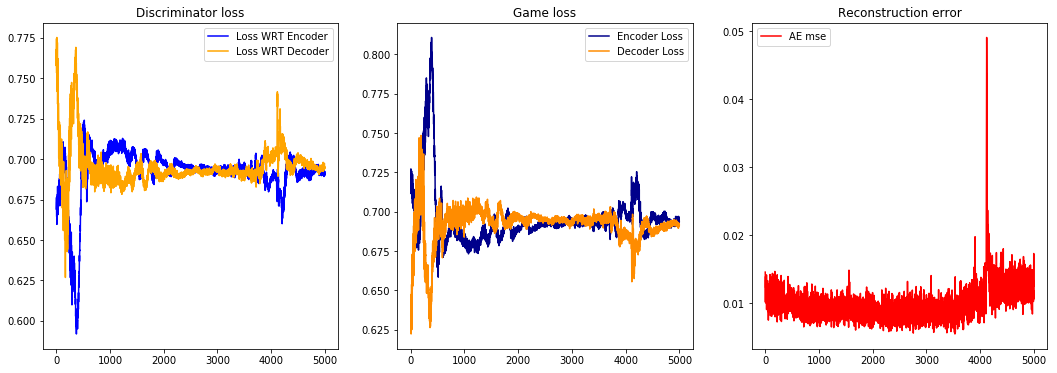

In [11]:
epochs = range(train_steps)
file_name = "%02dcylce" % (n_cycle)

lossFig = plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(epochs, discriminator_history[:,0], 'b', label='Loss WRT Encoder')
plt.plot(epochs, discriminator_history[:,1], 'orange', label='Loss WRT Decoder')
plt.title('Discriminator loss')
plt.legend(loc="best")
plt.subplot(1, 3, 2)
plt.plot(epochs, game_history[:,0], 'darkblue', label='Encoder Loss')
plt.plot(epochs, game_history[:,1], 'darkorange', label='Decoder Loss')
plt.title('Game loss')
plt.legend(loc="best")
plt.subplot(1, 3, 3)
plt.plot(epochs, ae_mse[:], 'r', label='AE mse')
plt.title('Reconstruction error')
plt.legend(loc="best")
plt.show()
lossFig.savefig(file_name + "Loss.png")

### Figure of merit

AE output:  (50000, 13)
50000 25000


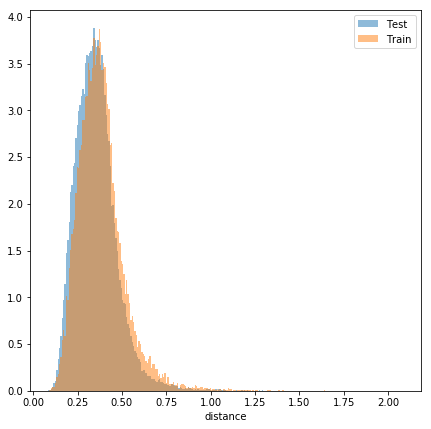

In [12]:
# on test data
encoded_imgs = encoder.predict(sample_test)
decoded_imgs = decoder.predict(encoded_imgs)

# on train data
encoded_imgs_train = encoder.predict(sample_train)
decoded_imgs_train = decoder.predict(encoded_imgs_train)

#print("compressed data:Dense(Dense( ", encoded_imgs.shape)
print("AE output: ", decoded_imgs.shape)

from numpy.linalg import norm

norm_test=[]
for i in range(sample_test.shape[0]):
    norm_test += [norm(sample_test[i,:]-decoded_imgs[i,:])]

norm_train=[]
for i in range(sample_train.shape[0]):
    norm_train += [norm(sample_train[i,:]-decoded_imgs_train[i,:])]

    
print(len(norm_test), len(norm_train))

#bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(7, 7))
n, bins, patches = plt.hist(norm_test, bins='auto', alpha=0.5, label='Test', density=True)
plt.hist(norm_train, bins, alpha=0.5, label='Train', density=True)
plt.xlabel('distance')
plt.legend(loc='upper right')
plt.savefig(file_name + "FoM.png")

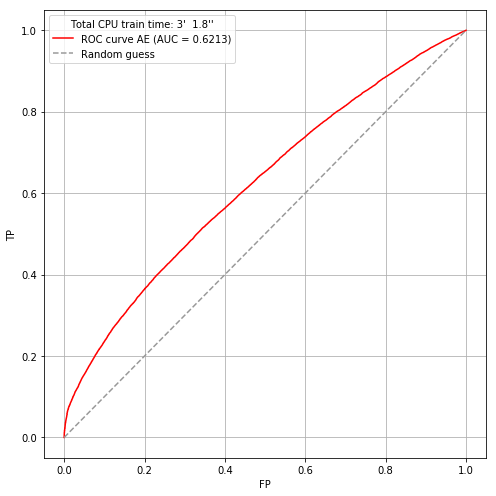

In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

target = np.concatenate((np.zeros(sample_train.shape[0] + n_test_sig),np.ones(n_test_sig)))
scores = np.concatenate((norm_train,norm_test))  

train_min = int(train_time) // 60
train_sec = train_time - 60 * train_min
time_stamp = "Total CPU train time: %d'  %.1f''" % (train_min, train_sec)

plt.figure(figsize=(7, 7))
                   
fp, vp, thresholds = roc_curve(target,scores,pos_label=0)
roc_auc = auc(fp, vp)

plt.plot(fp,vp,color='red',label='ROC curve %s (AUC = %0.4f)'%('AE',roc_auc))

plt.xlabel('FP')
plt.ylabel('TP')
plt.plot([0, 1],[0, 1],
         linestyle='--',color=(0.6, 0.6, 0.6),
         label='Random guess')
#plt.plot([0, 0, 1],[0, 1, 1],color='yellow',label='Idéal')
plt.grid()
plt.legend(loc="best", title =time_stamp)
plt.tight_layout()
plt.savefig(file_name + "ROC.png")